In [18]:
# Comprehensive EDA for Sales Conversion Prediction
# Production-Level Analysis with Business and Technical Insights

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import missingno as msno

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

class SalesConversionEDA:
    """
    Comprehensive EDA class for Sales Conversion Prediction
    Includes both business and technical analysis
    """
    
    def __init__(self, df):
        self.df = df.copy()
        self.target = 'Converted'
        self.numerical_features = []
        self.categorical_features = []
        self.business_insights = {}
        self.technical_insights = {}
        
    def initial_data_overview(self):
        """
        Initial data exploration and overview
        """
        print("="*80)
        print("INITIAL DATA OVERVIEW")
        print("="*80)
        
        print(f"Dataset Shape: {self.df.shape}")
        print(f"Total Records: {self.df.shape[0]:,}")
        print(f"Total Features: {self.df.shape[1]:,}")
        
        print("\nFirst 5 rows:")
        print(self.df.head())
        
        print("\nDataset Info:")
        print(self.df.info())
        
        print("\nBasic Statistics:")
        print(self.df.describe())
        
        # Target variable distribution
        print(f"\nTarget Variable Distribution:")
        target_dist = self.df[self.target].value_counts()
        print(target_dist)
        print(f"Conversion Rate: {target_dist[1]/target_dist.sum()*100:.2f}%")
        
        # Store business insight
        self.business_insights['conversion_rate'] = target_dist[1]/target_dist.sum()*100
        
    def data_quality_assessment(self):
        """
        Comprehensive data quality assessment
        """
        print("="*80)
        print("DATA QUALITY ASSESSMENT")
        print("="*80)
        
        # Missing values analysis
        missing_data = self.df.isnull().sum()
        missing_percent = (missing_data / len(self.df)) * 100
        
        missing_df = pd.DataFrame({
            'Column': missing_data.index,
            'Missing_Count': missing_data.values,
            'Missing_Percentage': missing_percent.values
        }).sort_values('Missing_Percentage', ascending=False)
        
        print("Missing Values Summary:")
        print(missing_df[missing_df['Missing_Count'] > 0])
        
        # Visualize missing data
        plt.figure(figsize=(15, 8))
        msno.matrix(self.df)
        plt.title('Missing Data Pattern')
        plt.tight_layout()
        plt.show()
        
        # Duplicate records
        duplicates = self.df.duplicated().sum()
        print(f"\nDuplicate Records: {duplicates}")
        
        # Data types analysis
        print("\nData Types Distribution:")
        dtype_counts = self.df.dtypes.value_counts()
        print(dtype_counts)
        
        # Store technical insights
        self.technical_insights['missing_data'] = missing_df
        self.technical_insights['duplicates'] = duplicates
        
    def feature_categorization(self):
        """
        Categorize features into numerical and categorical
        """
        print("="*80)
        print("FEATURE CATEGORIZATION")
        print("="*80)
        
        # Identify numerical and categorical features
        self.numerical_features = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_features = self.df.select_dtypes(include=['object']).columns.tolist()
        
        # Remove target and ID columns
        if self.target in self.numerical_features:
            self.numerical_features.remove(self.target)
        if 'Prospect ID' in self.categorical_features:
            self.categorical_features.remove('Prospect ID')
        if 'Lead Number' in self.numerical_features:
            self.numerical_features.remove('Lead Number')
            
        print(f"Numerical Features ({len(self.numerical_features)}):")
        print(self.numerical_features)
        
        print(f"\nCategorical Features ({len(self.categorical_features)}):")
        print(self.categorical_features)
        
    def univariate_analysis(self):
        """
        Detailed univariate analysis for all features
        """
        print("="*80)
        print("UNIVARIATE ANALYSIS")
        print("="*80)
        
        # Target variable analysis
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        target_counts = self.df[self.target].value_counts()
        plt.pie(target_counts.values, labels=['Not Converted', 'Converted'], 
                autopct='%1.1f%%', startangle=90)
        plt.title('Target Variable Distribution')
        
        plt.subplot(1, 2, 2)
        sns.countplot(data=self.df, x=self.target)
        plt.title('Target Variable Count')
        plt.tight_layout()
        plt.show()
        
        # Numerical features analysis
        if self.numerical_features:
            n_cols = 3
            n_rows = (len(self.numerical_features) + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
            axes = axes.flatten() if n_rows > 1 else [axes]
            
            for i, feature in enumerate(self.numerical_features):
                if i < len(axes):
                    # Distribution plot
                    sns.histplot(self.df[feature].dropna(), kde=True, ax=axes[i])
                    axes[i].set_title(f'{feature} Distribution')
                    axes[i].tick_params(axis='x', rotation=45)
                    
                    # Add statistics
                    mean_val = self.df[feature].mean()
                    median_val = self.df[feature].median()
                    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
                    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
                    axes[i].legend()
            
            # Hide empty subplots
            for i in range(len(self.numerical_features), len(axes)):
                axes[i].set_visible(False)
                
            plt.tight_layout()
            plt.show()
        
        # Categorical features analysis (top categories)
        if self.categorical_features:
            for feature in self.categorical_features[:6]:  # Show first 6 categorical features
                plt.figure(figsize=(12, 6))
                
                # Count plot
                top_categories = self.df[feature].value_counts().head(10)
                
                plt.subplot(1, 2, 1)
                sns.countplot(data=self.df, y=feature, order=top_categories.index)
                plt.title(f'{feature} - Top 10 Categories')
                
                # Pie chart for top categories
                plt.subplot(1, 2, 2)
                if len(top_categories) <= 8:
                    plt.pie(top_categories.values, labels=top_categories.index, autopct='%1.1f%%')
                else:
                    other_sum = self.df[feature].value_counts().iloc[8:].sum()
                    pie_data = top_categories.iloc[:8].tolist() + [other_sum]
                    pie_labels = top_categories.iloc[:8].index.tolist() + ['Others']
                    plt.pie(pie_data, labels=pie_labels, autopct='%1.1f%%')
                
                plt.title(f'{feature} Distribution')
                plt.tight_layout()
                plt.show()
                
    def bivariate_analysis(self):
        """
        Comprehensive bivariate analysis with target variable
        """
        print("="*80)
        print("BIVARIATE ANALYSIS")
        print("="*80)
        
        # Numerical features vs Target
        if self.numerical_features:
            n_cols = 2
            n_rows = (len(self.numerical_features) + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))
            axes = axes.flatten() if n_rows > 1 else [axes]
            
            for i, feature in enumerate(self.numerical_features):
                if i < len(axes):
                    # Box plot
                    sns.boxplot(data=self.df, x=self.target, y=feature, ax=axes[i])
                    axes[i].set_title(f'{feature} vs Conversion')
                    
                    # Statistical test
                    converted = self.df[self.df[self.target] == 1][feature].dropna()
                    not_converted = self.df[self.df[self.target] == 0][feature].dropna()
                    
                    if len(converted) > 0 and len(not_converted) > 0:
                        stat, p_value = stats.mannwhitneyu(converted, not_converted, alternative='two-sided')
                        axes[i].text(0.5, 0.95, f'p-value: {p_value:.4f}', 
                                   transform=axes[i].transAxes, ha='center', va='top')
            
            # Hide empty subplots
            for i in range(len(self.numerical_features), len(axes)):
                axes[i].set_visible(False)
                
            plt.tight_layout()
            plt.show()
        
        # Categorical features vs Target
        significant_associations = []
        
        for feature in self.categorical_features[:8]:  # Analyze first 8 categorical features
            plt.figure(figsize=(15, 6))
            
            # Cross-tabulation
            crosstab = pd.crosstab(self.df[feature], self.df[self.target])
            
            # Conversion rate by category
            conversion_rate = crosstab.div(crosstab.sum(axis=1), axis=0)[1] * 100
            
            plt.subplot(1, 3, 1)
            sns.countplot(data=self.df, x=self.target, hue=feature)
            plt.title(f'{feature} vs Conversion - Count')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.subplot(1, 3, 2)
            crosstab.plot(kind='bar', ax=plt.gca())
            plt.title(f'{feature} vs Conversion - Stacked')
            plt.xticks(rotation=45)
            
            plt.subplot(1, 3, 3)
            conversion_rate.plot(kind='bar', color='skyblue')
            plt.title(f'Conversion Rate by {feature}')
            plt.ylabel('Conversion Rate (%)')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            # Chi-square test
            try:
                chi2, p_value, dof, expected = chi2_contingency(crosstab)
                if p_value < 0.05:
                    significant_associations.append((feature, p_value, chi2))
                    print(f"{feature}: Chi-square = {chi2:.4f}, p-value = {p_value:.4f} (Significant)")
                else:
                    print(f"{feature}: Chi-square = {chi2:.4f}, p-value = {p_value:.4f} (Not Significant)")
            except:
                print(f"{feature}: Chi-square test could not be performed")
        
        self.business_insights['significant_associations'] = significant_associations
        
    def correlation_analysis(self):
        """
        Correlation analysis for numerical features
        """
        print("="*80)
        print("CORRELATION ANALYSIS")
        print("="*80)
        
        if len(self.numerical_features) > 1:
            # Correlation matrix
            numerical_df = self.df[self.numerical_features + [self.target]]
            correlation_matrix = numerical_df.corr()
            
            # Heatmap
            plt.figure(figsize=(12, 10))
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
            sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                       square=True, linewidths=0.5, cbar_kws={"shrink": .8})
            plt.title('Correlation Matrix')
            plt.tight_layout()
            plt.show()
            
            # Correlation with target
            target_corr = correlation_matrix[self.target].drop(self.target).sort_values(key=abs, ascending=False)
            print("\nCorrelation with Target Variable:")
            print(target_corr)
            
            # High correlation pairs (multicollinearity check)
            high_corr_pairs = []
            for i in range(len(correlation_matrix.columns)):
                for j in range(i+1, len(correlation_matrix.columns)):
                    if abs(correlation_matrix.iloc[i, j]) > 0.7:
                        high_corr_pairs.append((
                            correlation_matrix.columns[i], 
                            correlation_matrix.columns[j], 
                            correlation_matrix.iloc[i, j]
                        ))
            
            if high_corr_pairs:
                print("\nHigh Correlation Pairs (>0.7):")
                for pair in high_corr_pairs:
                    print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")
            
            self.technical_insights['high_correlation'] = high_corr_pairs
            
    def advanced_analysis(self):
        """
        Advanced analysis including feature importance and business insights
        """
        print("="*80)
        print("ADVANCED ANALYSIS")
        print("="*80)
        
        # Feature importance using mutual information
        # Prepare data for mutual information
        df_encoded = self.df.copy()
        
        # Label encode categorical variables
        le = LabelEncoder()
        for feature in self.categorical_features:
            df_encoded[feature] = le.fit_transform(df_encoded[feature].astype(str))
        
        # Calculate mutual information
        features = self.numerical_features + self.categorical_features
        X = df_encoded[features].fillna(0)
        y = df_encoded[self.target]
        
        mi_scores = mutual_info_classif(X, y, random_state=42)
        mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        mi_scores.head(15).plot(kind='barh')
        plt.title('Feature Importance (Mutual Information)')
        plt.xlabel('Mutual Information Score')
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        print(mi_scores.head(10))
        
        # Business insights analysis
        self.generate_business_insights()
        
        self.technical_insights['feature_importance'] = mi_scores
        
    def generate_business_insights(self):
        """
        Generate business-specific insights
        """
        print("="*80)
        print("BUSINESS INSIGHTS")
        print("="*80)
        
        # Lead source analysis
        if 'Lead Source' in self.df.columns:
            lead_source_conversion = self.df.groupby('Lead Source')[self.target].agg(['count', 'sum', 'mean'])
            lead_source_conversion.columns = ['Total_Leads', 'Conversions', 'Conversion_Rate']
            lead_source_conversion = lead_source_conversion.sort_values('Conversion_Rate', ascending=False)
            
            print("Lead Source Performance:")
            print(lead_source_conversion)
            
            # Visualize lead source performance
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            lead_source_conversion['Total_Leads'].plot(kind='bar')
            plt.title('Total Leads by Source')
            plt.xticks(rotation=45)
            
            plt.subplot(1, 2, 2)
            lead_source_conversion['Conversion_Rate'].plot(kind='bar', color='green')
            plt.title('Conversion Rate by Lead Source')
            plt.xticks(rotation=45)
            plt.ylabel('Conversion Rate')
            
            plt.tight_layout()
            plt.show()
            
            self.business_insights['lead_source_performance'] = lead_source_conversion
        
        # Website engagement analysis
        website_features = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
        website_features = [f for f in website_features if f in self.df.columns]
        
        if website_features:
            print("\nWebsite Engagement Analysis:")
            for feature in website_features:
                converted_avg = self.df[self.df[self.target] == 1][feature].mean()
                not_converted_avg = self.df[self.df[self.target] == 0][feature].mean()
                
                print(f"{feature}:")
                print(f"  Converted: {converted_avg:.2f}")
                print(f"  Not Converted: {not_converted_avg:.2f}")
                print(f"  Difference: {((converted_avg - not_converted_avg) / not_converted_avg * 100):.2f}%")
        
        # Activity-based insights
        if 'Last Activity' in self.df.columns:
            activity_conversion = self.df.groupby('Last Activity')[self.target].agg(['count', 'mean'])
            activity_conversion.columns = ['Count', 'Conversion_Rate']
            activity_conversion = activity_conversion.sort_values('Conversion_Rate', ascending=False)
            
            print("\nLast Activity Performance:")
            print(activity_conversion.head(10))
            
            self.business_insights['activity_performance'] = activity_conversion
            
    def outlier_analysis(self):
        """
        Comprehensive outlier analysis
        """
        print("="*80)
        print("OUTLIER ANALYSIS")
        print("="*80)
        
        if self.numerical_features:
            outlier_summary = {}
            
            for feature in self.numerical_features:
                Q1 = self.df[feature].quantile(0.25)
                Q3 = self.df[feature].quantile(0.75)
                IQR = Q3 - Q1
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = self.df[(self.df[feature] < lower_bound) | (self.df[feature] > upper_bound)]
                outlier_percentage = (len(outliers) / len(self.df)) * 100
                
                outlier_summary[feature] = {
                    'outlier_count': len(outliers),
                    'outlier_percentage': outlier_percentage,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                }
                
                print(f"{feature}: {len(outliers)} outliers ({outlier_percentage:.2f}%)")
            
            # Visualize outliers
            n_cols = 2
            n_rows = (len(self.numerical_features) + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))
            axes = axes.flatten() if n_rows > 1 else [axes]
            
            for i, feature in enumerate(self.numerical_features):
                if i < len(axes):
                    sns.boxplot(data=self.df, y=feature, ax=axes[i])
                    axes[i].set_title(f'{feature} - Outlier Detection')
            
            # Hide empty subplots
            for i in range(len(self.numerical_features), len(axes)):
                axes[i].set_visible(False)
                
            plt.tight_layout()
            plt.show()
            
            self.technical_insights['outliers'] = outlier_summary
            
    def generate_final_report(self):
        """
        Generate comprehensive final report
        """
        print("="*100)
        print("COMPREHENSIVE EDA REPORT - SALES CONVERSION PREDICTION")
        print("="*100)
        
        print("\n1. DATASET OVERVIEW:")
        print(f"   - Total Records: {self.df.shape[0]:,}")
        print(f"   - Total Features: {self.df.shape[1]:,}")
        print(f"   - Conversion Rate: {self.business_insights.get('conversion_rate', 0):.2f}%")
        
        print("\n2. DATA QUALITY:")
        missing_df = self.technical_insights.get('missing_data', pd.DataFrame())
        if not missing_df.empty:
            high_missing = missing_df[missing_df['Missing_Percentage'] > 30]
            print(f"   - Features with >30% missing values: {len(high_missing)}")
            
        print(f"   - Duplicate records: {self.technical_insights.get('duplicates', 0)}")
        
        print("\n3. KEY BUSINESS INSIGHTS:")
        
        # Lead source insights
        if 'lead_source_performance' in self.business_insights:
            best_source = self.business_insights['lead_source_performance'].iloc[0]
            print(f"   - Best performing lead source: {best_source.name} ({best_source['Conversion_Rate']:.2f}% conversion)")
        
        # Feature importance
        if 'feature_importance' in self.technical_insights:
            top_features = self.technical_insights['feature_importance'].head(5)
            print(f"   - Top 5 predictive features: {', '.join(top_features.index)}")
        
        # Significant associations
        if 'significant_associations' in self.business_insights:
            sig_count = len(self.business_insights['significant_associations'])
            print(f"   - Features with significant association with conversion: {sig_count}")
        
        print("\n4. TECHNICAL RECOMMENDATIONS:")
        
        # Missing value treatment
        if not missing_df.empty:
            high_missing = missing_df[missing_df['Missing_Percentage'] > 50]
            if not high_missing.empty:
                print(f"   - Consider removing features with >50% missing values: {list(high_missing['Column'])}")
        
        # Multicollinearity
        if 'high_correlation' in self.technical_insights:
            high_corr = self.technical_insights['high_correlation']
            if high_corr:
                print(f"   - Address multicollinearity between: {high_corr[0][0]} and {high_corr[0][1]}")
        
        # Outliers
        if 'outliers' in self.technical_insights:
            outlier_features = [f for f, info in self.technical_insights['outliers'].items() 
                              if info['outlier_percentage'] > 5]
            if outlier_features:
                print(f"   - Consider outlier treatment for: {', '.join(outlier_features)}")
        
        print("\n5. MODELING RECOMMENDATIONS:")
        print("   - Use stratified sampling due to class imbalance")
        print("   - Consider ensemble methods (Random Forest, XGBoost)")
        print("   - Implement proper cross-validation")
        print("   - Focus on precision and recall along with accuracy")
        
        print("\n" + "="*100)



In [6]:

df = pd.read_csv(r'C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\raw_data\Lead Scoring.csv')  
eda = SalesConversionEDA(df)

In [7]:
eda.initial_data_overview()

INITIAL DATA OVERVIEW
Dataset Shape: (9240, 37)
Total Records: 9,240
Total Features: 37

First 5 rows:
                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1       

DATA QUALITY ASSESSMENT
Missing Values Summary:
                                           Column  Missing_Count  \
25                                   Lead Quality           4767   
31                     Asymmetrique Profile Index           4218   
32                    Asymmetrique Activity Score           4218   
30                    Asymmetrique Activity Index           4218   
33                     Asymmetrique Profile Score           4218   
24                                           Tags           3353   
15  What matters most to you in choosing a course           2709   
28                                   Lead Profile           2709   
14                What is your current occupation           2690   
11                                        Country           2461   
13             How did you hear about X Education           2207   
12                                 Specialization           1438   
29                                           City           1420   


<Figure size 1500x800 with 0 Axes>

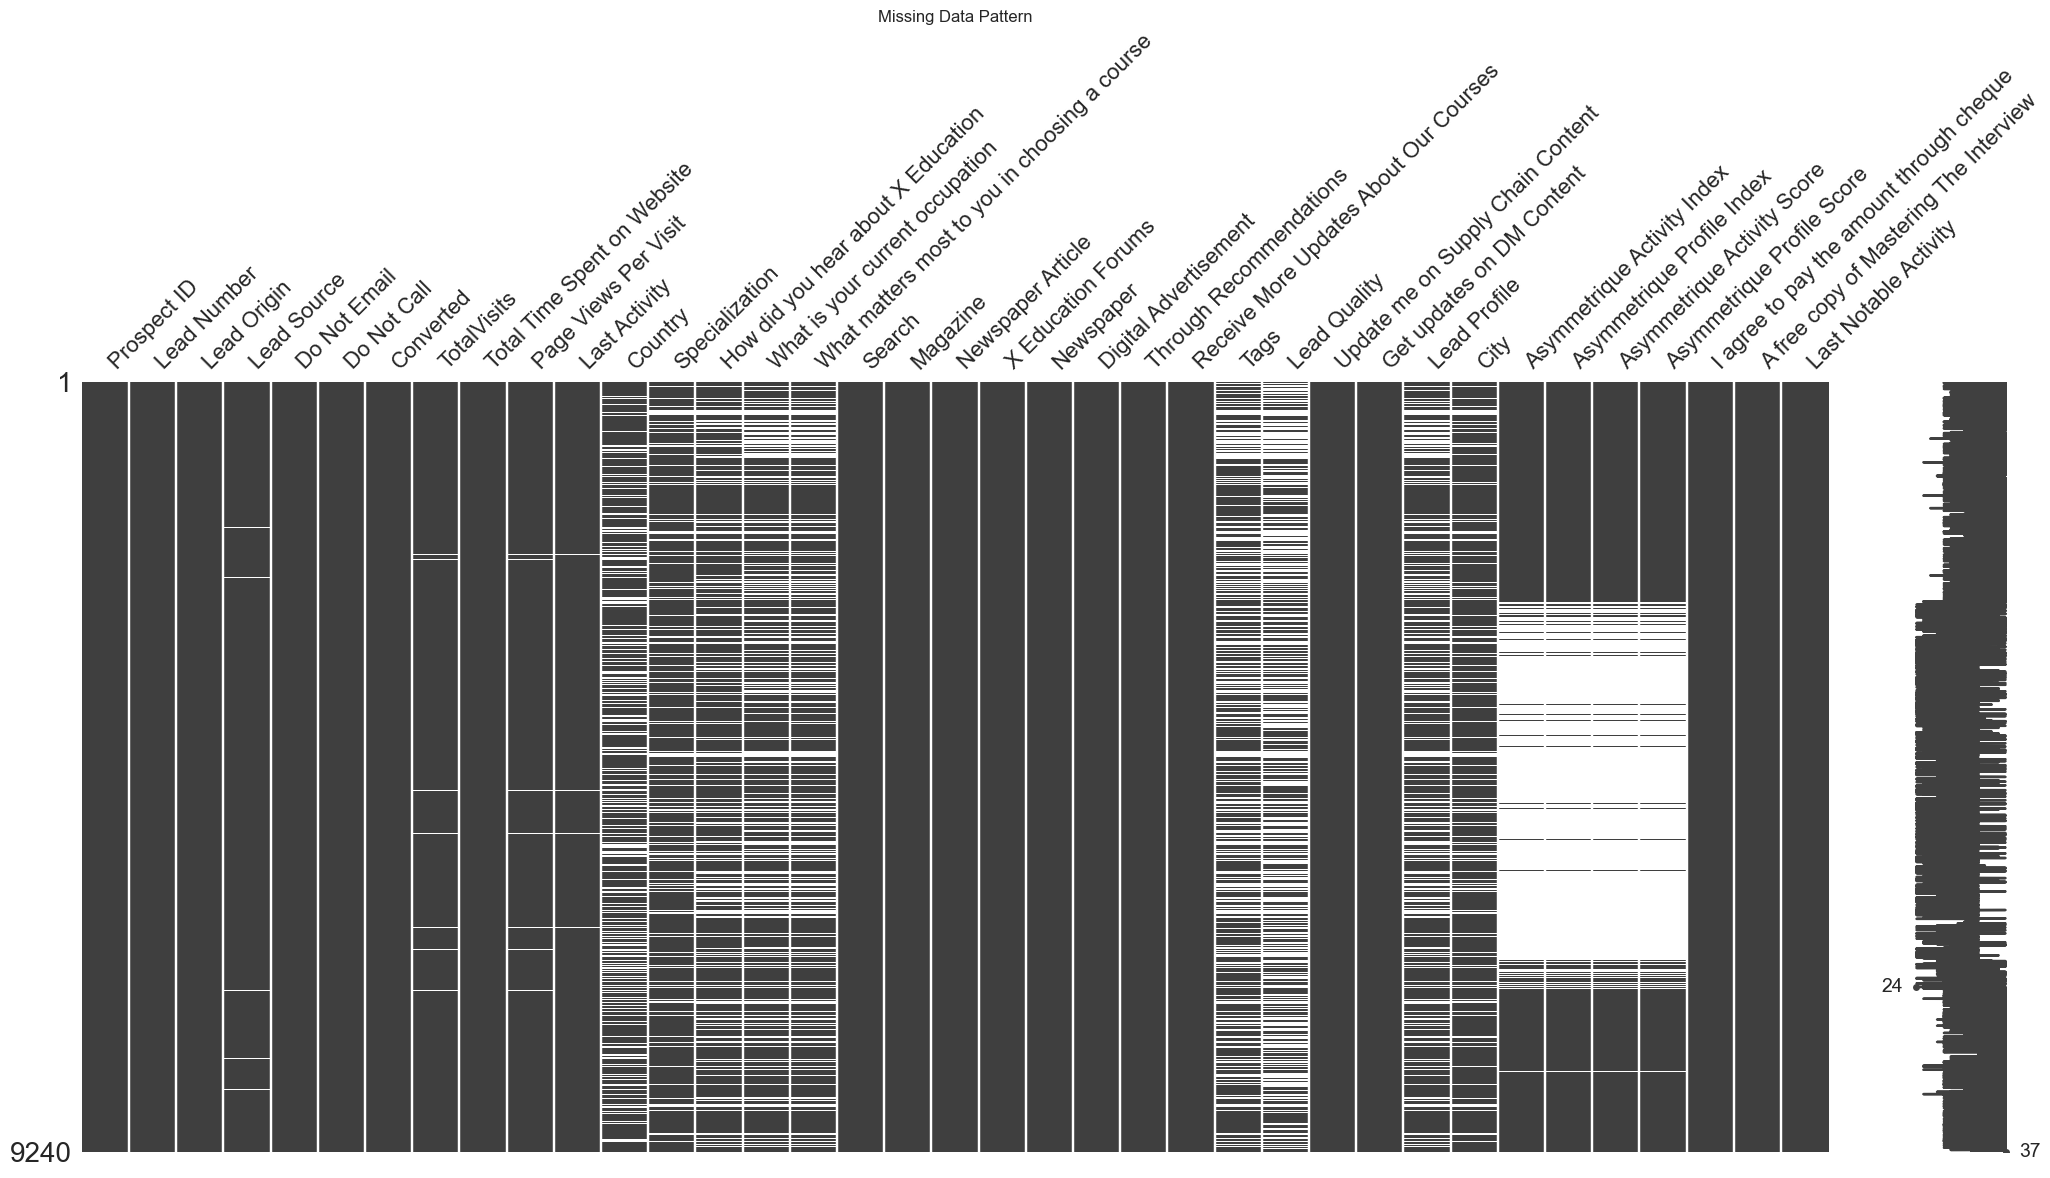


Duplicate Records: 0

Data Types Distribution:
object     30
float64     4
int64       3
Name: count, dtype: int64


In [9]:
eda.data_quality_assessment()


In [27]:
eda.initial_data_overview()


INITIAL DATA OVERVIEW
Dataset Shape: (9240, 37)
Total Records: 9,240
Total Features: 37

First 5 rows:
                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1       

In [25]:
eda.feature_categorization()


FEATURE CATEGORIZATION
Numerical Features (5):
['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']

Categorical Features (29):
['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


UNIVARIATE ANALYSIS


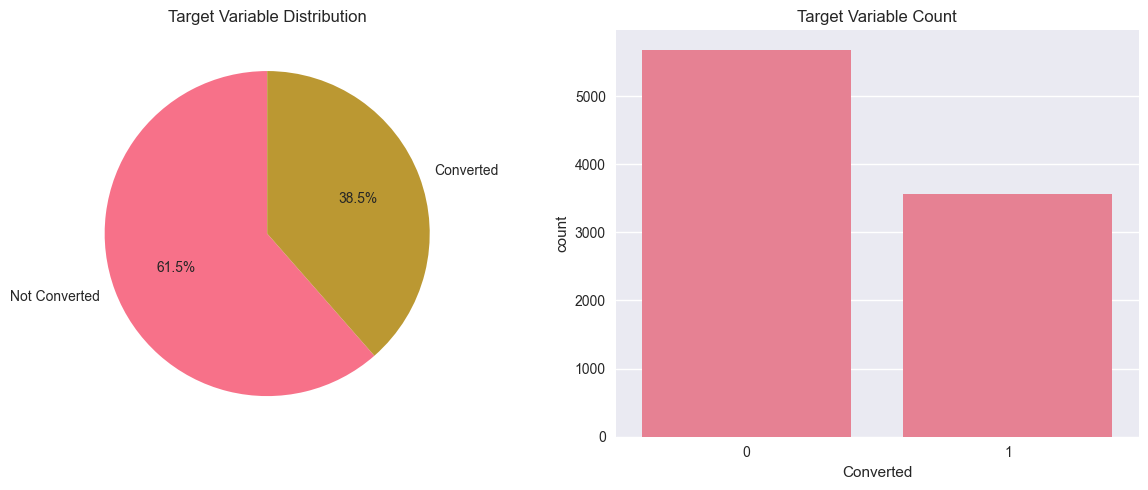

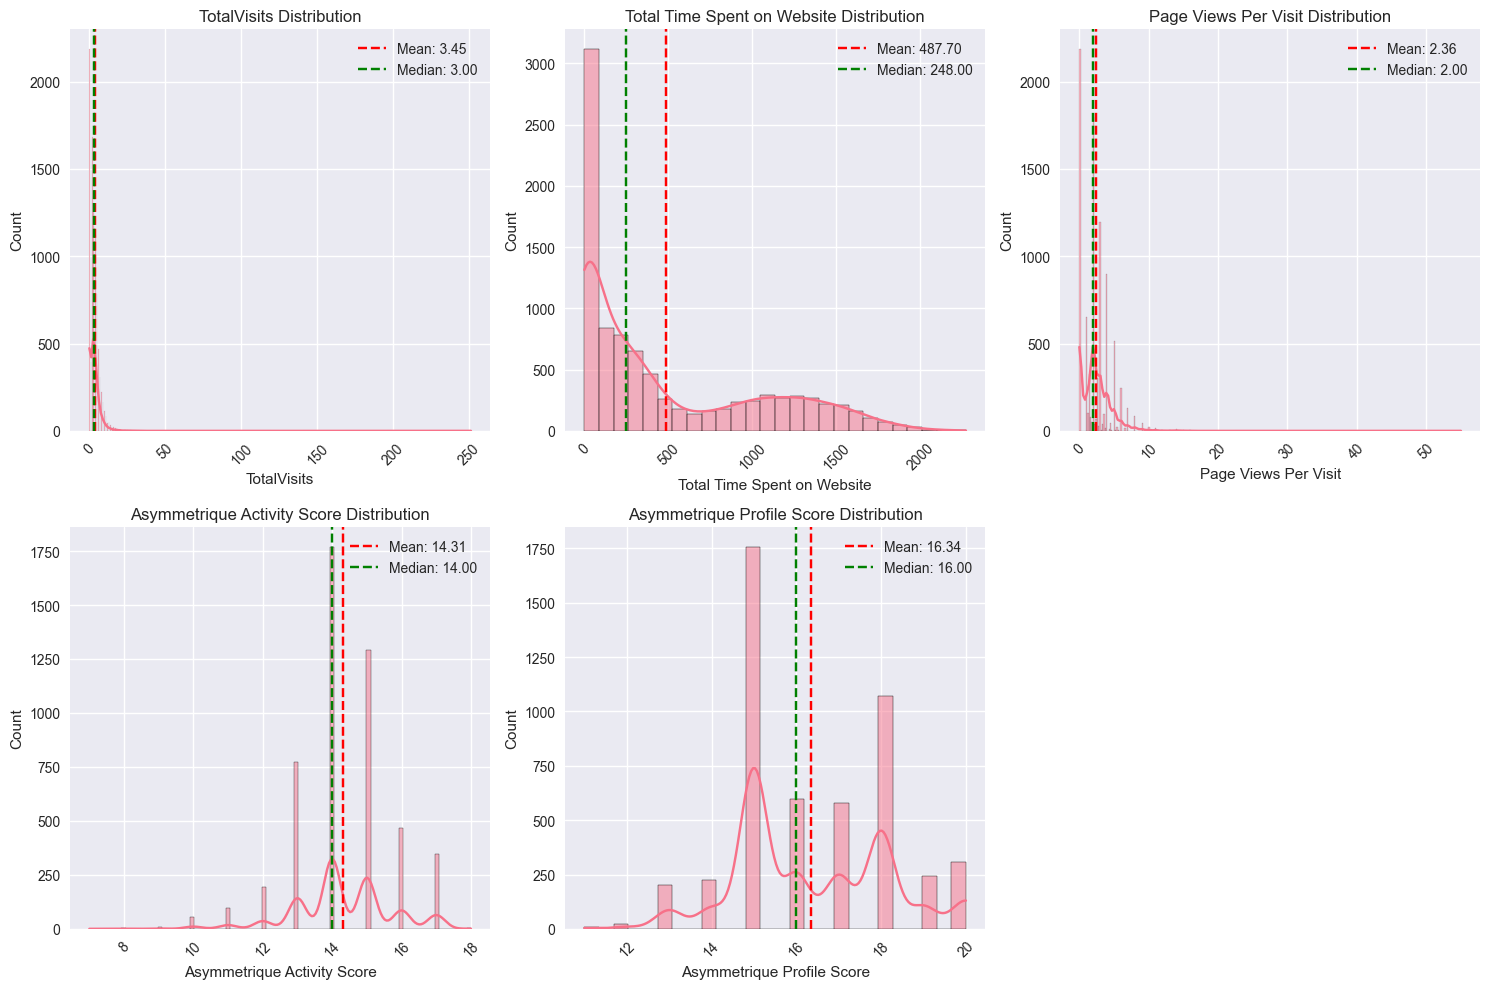

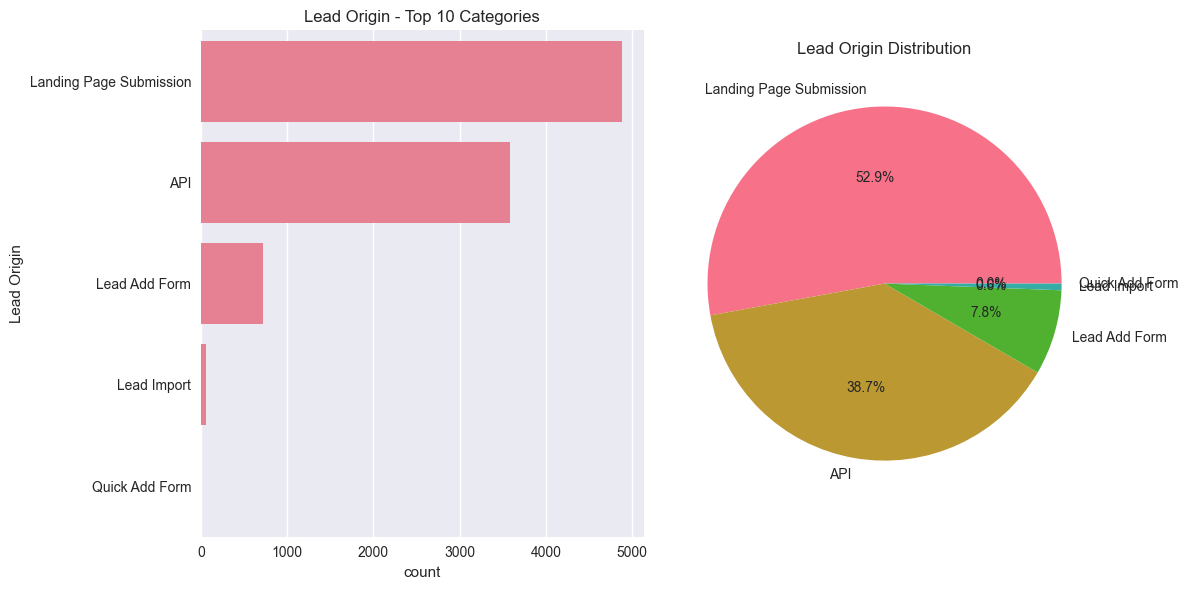

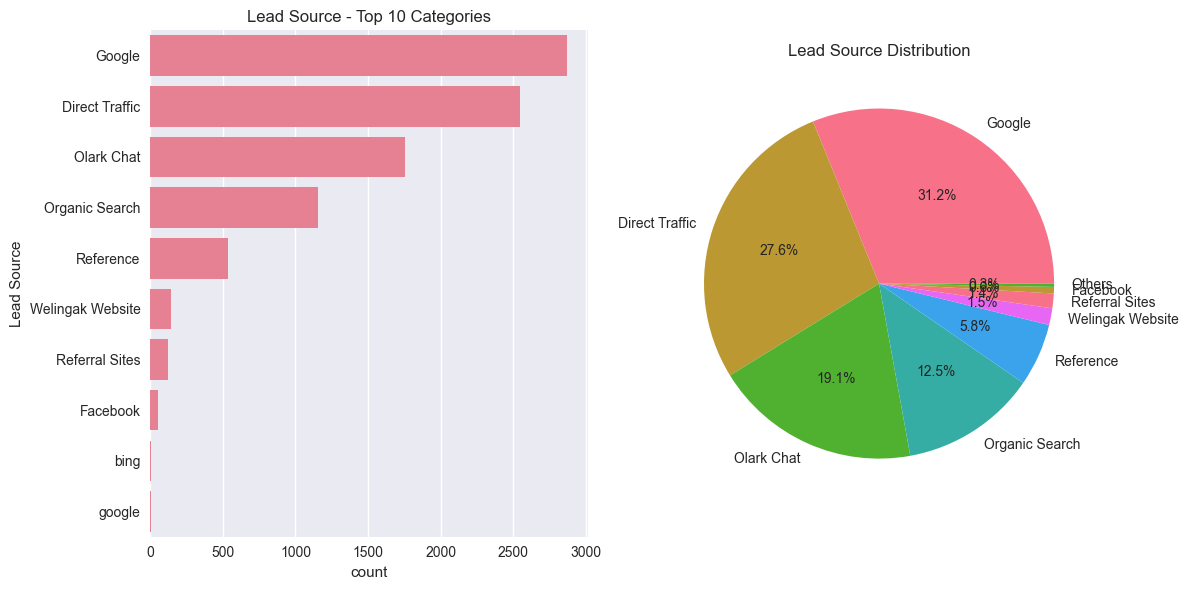

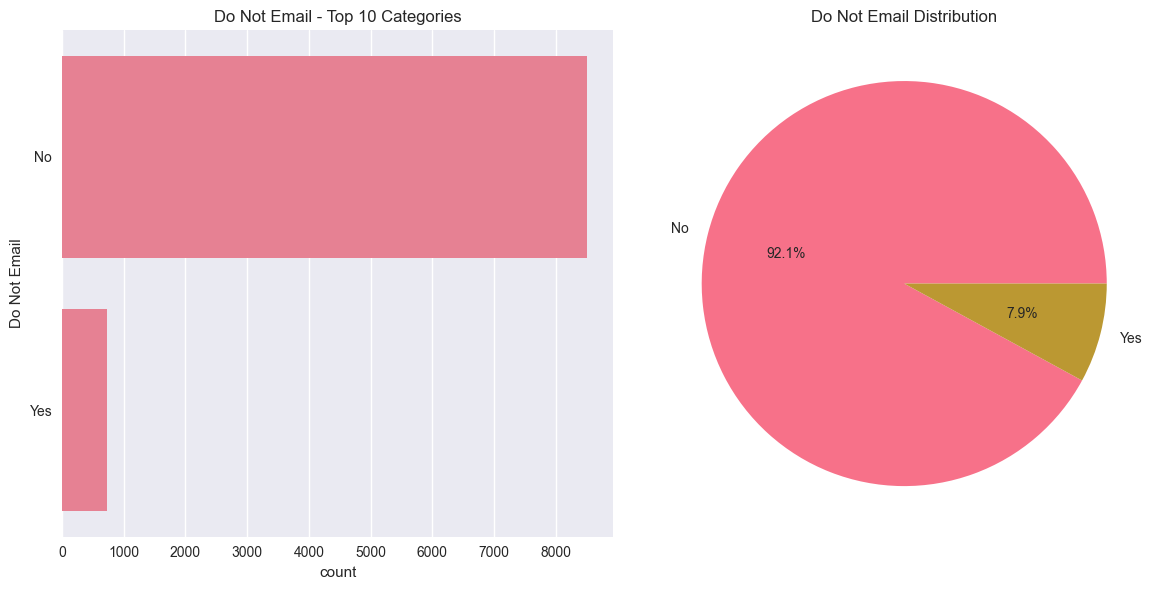

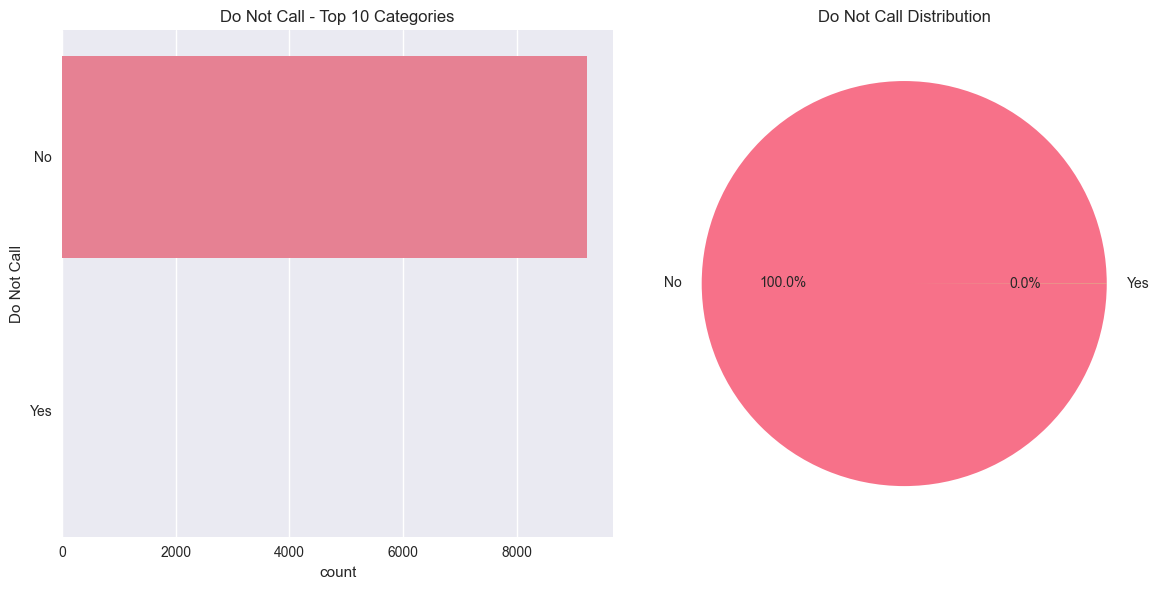

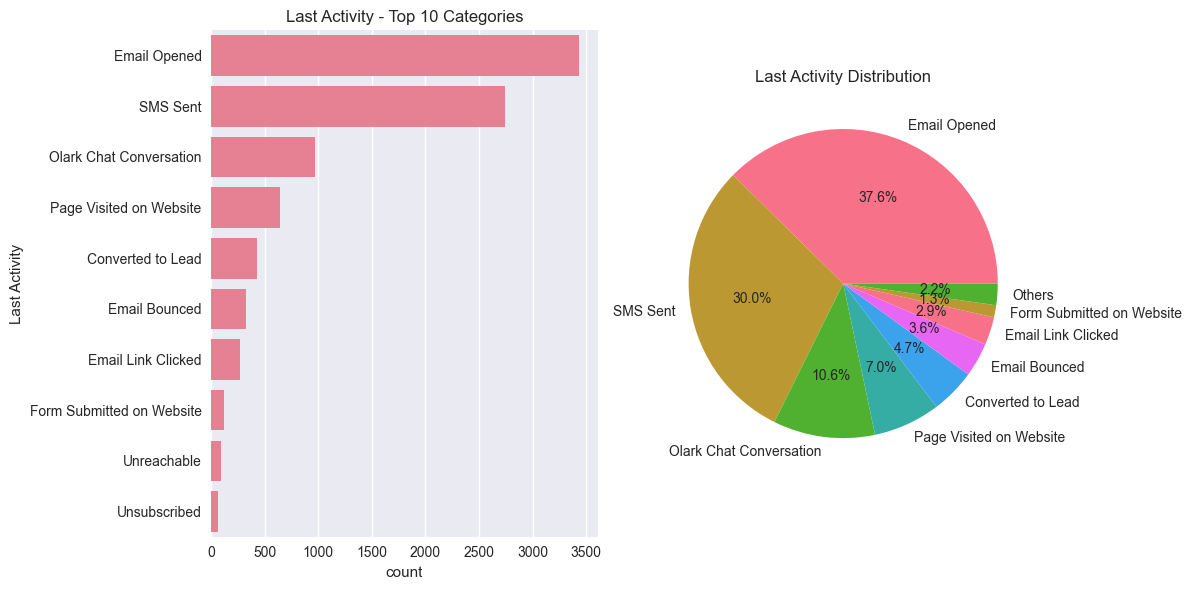

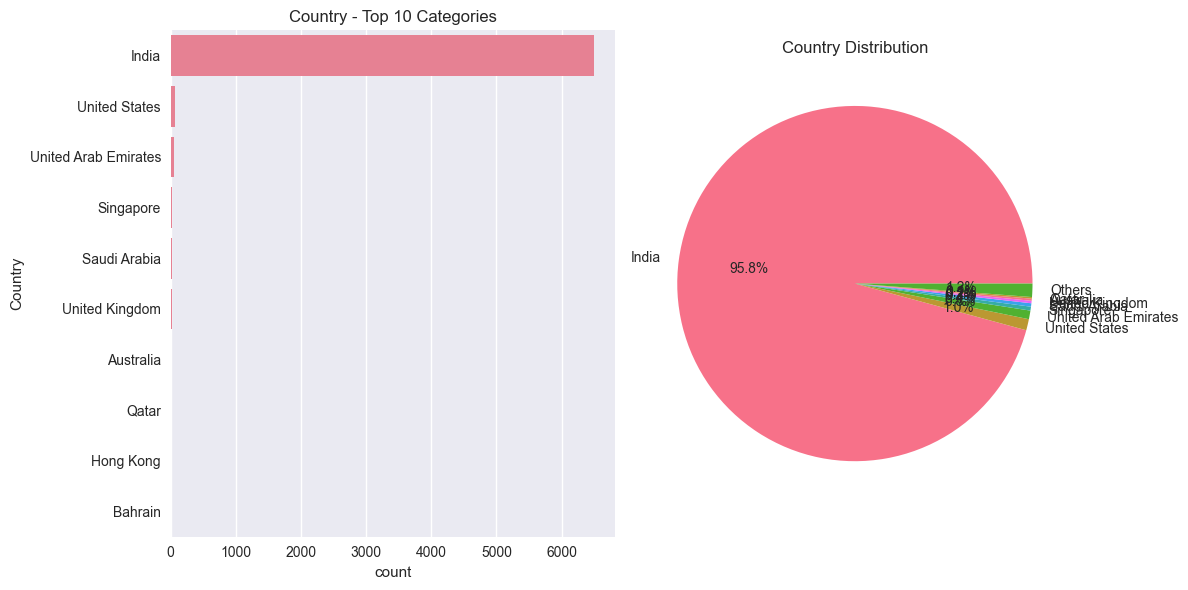

In [28]:
eda.univariate_analysis()


BIVARIATE ANALYSIS


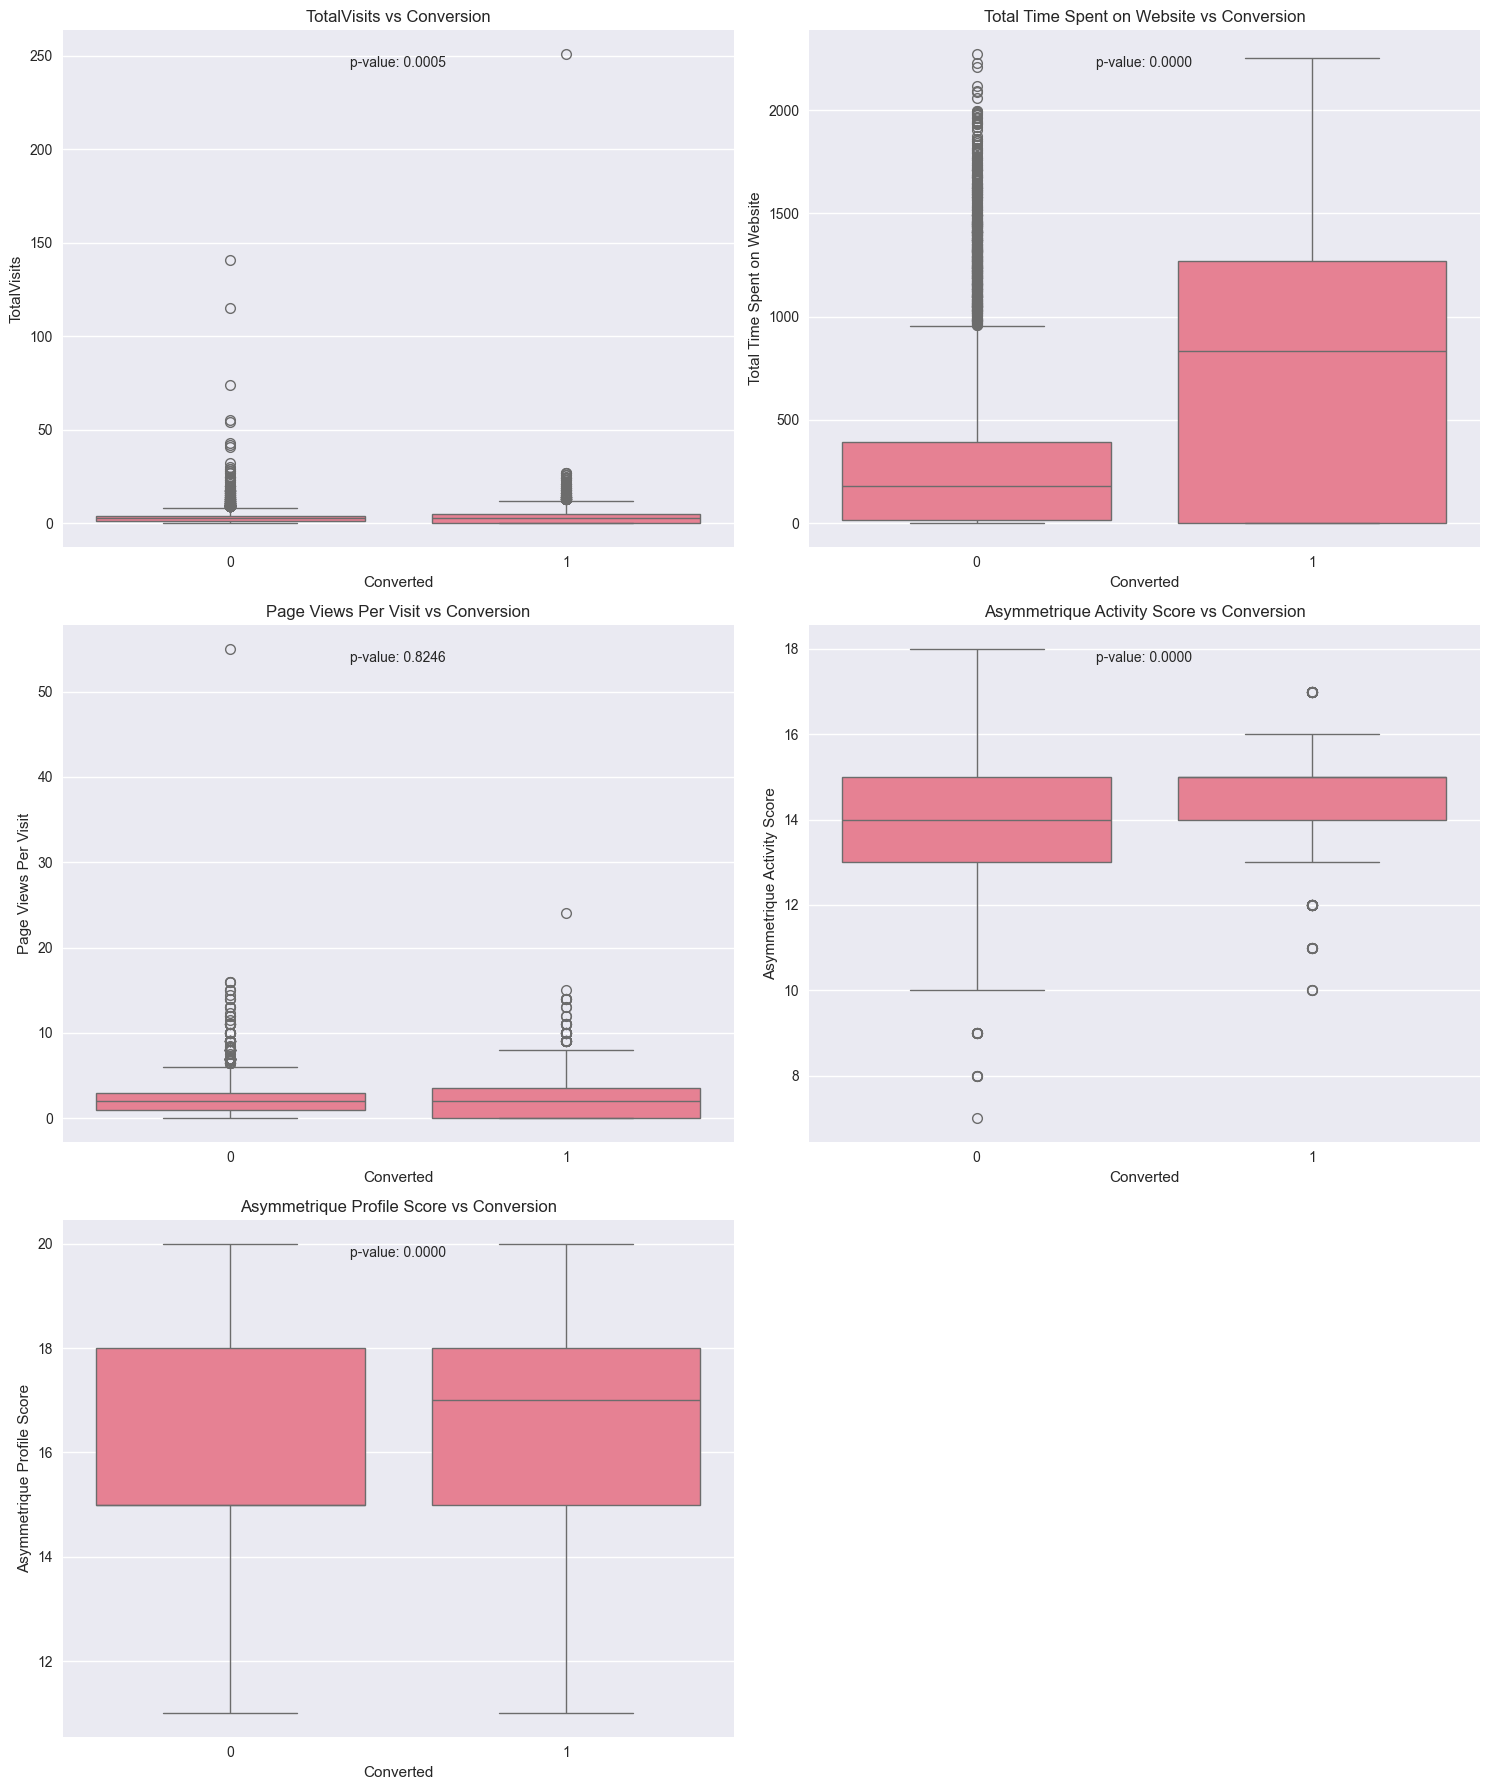

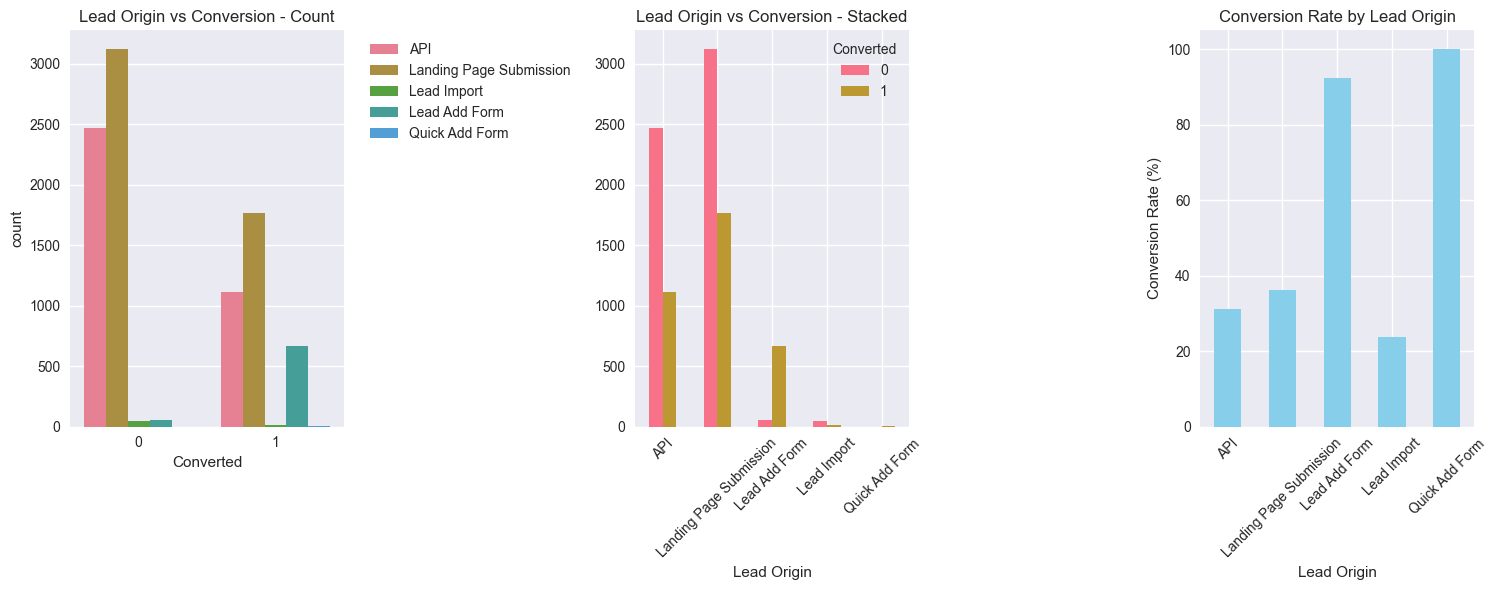

Lead Origin: Chi-square = 982.7658, p-value = 0.0000 (Significant)


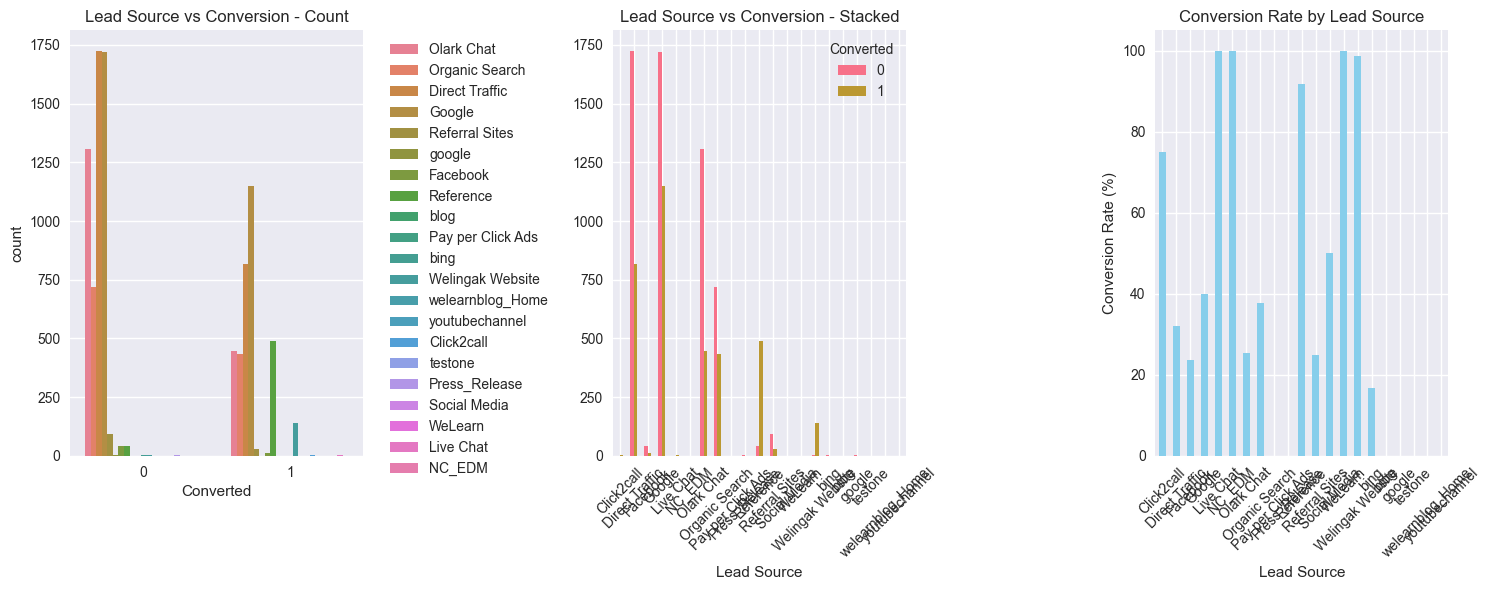

Lead Source: Chi-square = 1060.8387, p-value = 0.0000 (Significant)


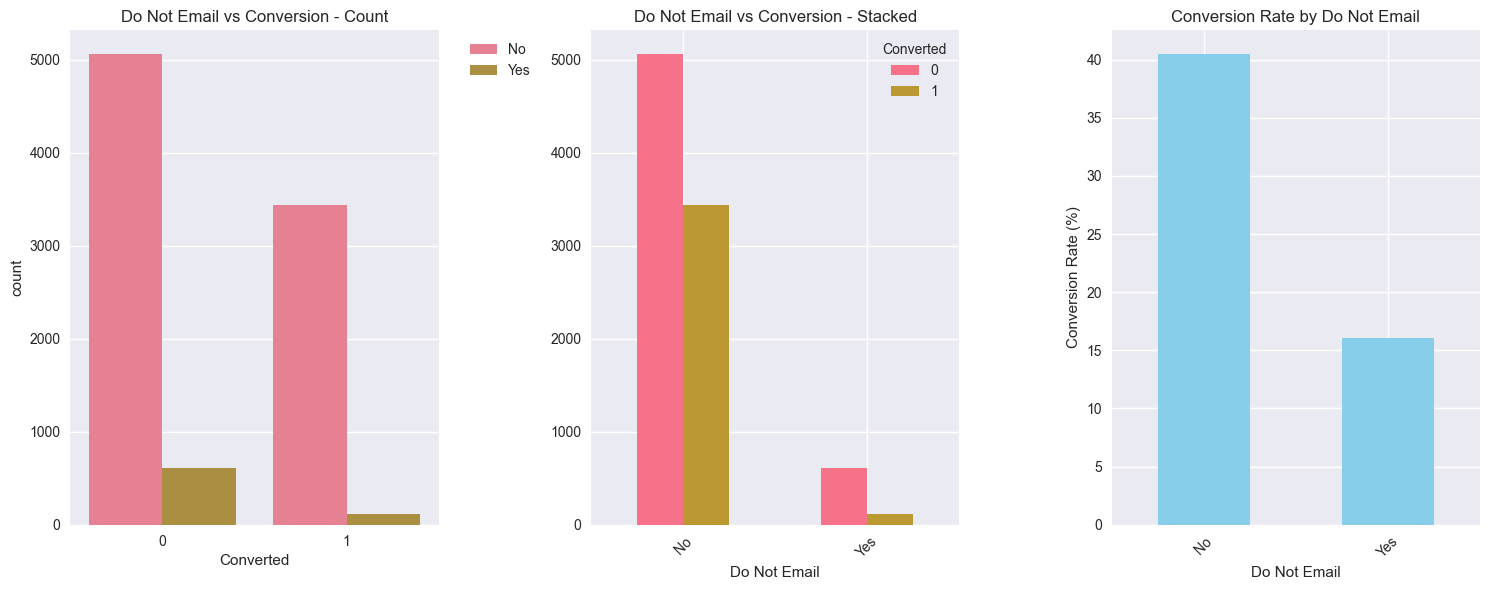

Do Not Email: Chi-square = 168.8213, p-value = 0.0000 (Significant)


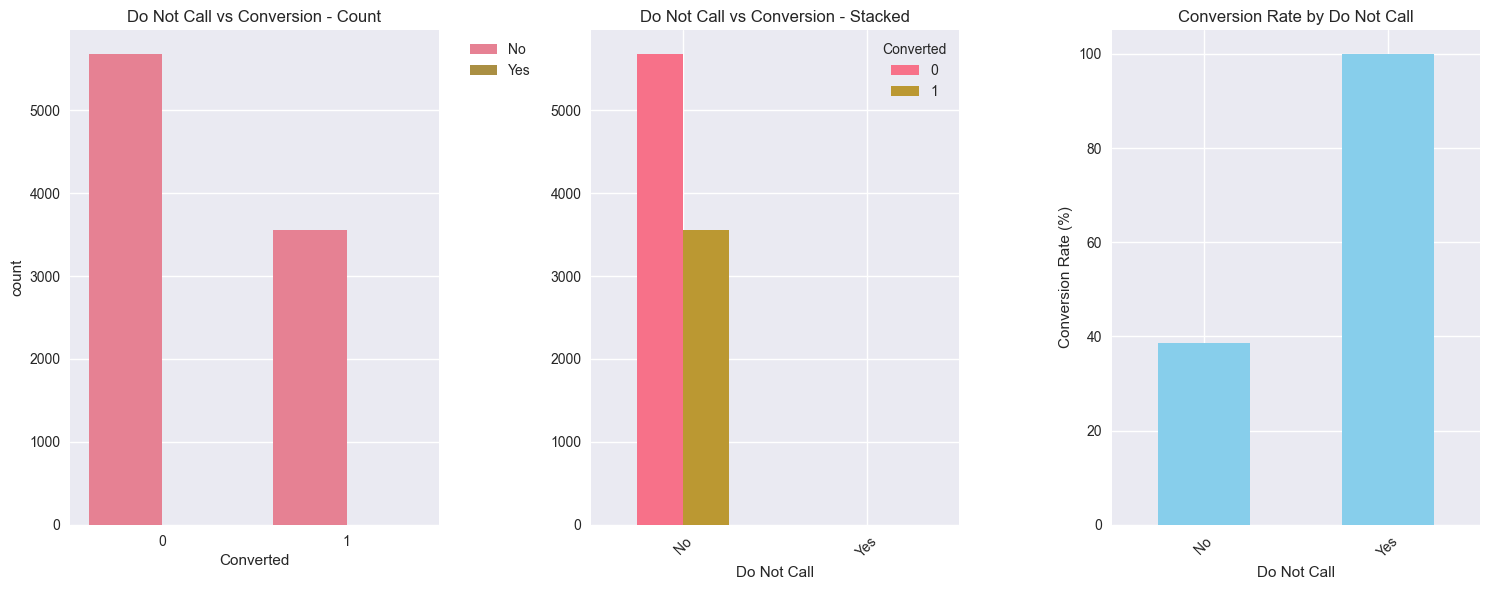

Do Not Call: Chi-square = 1.1227, p-value = 0.2893 (Not Significant)


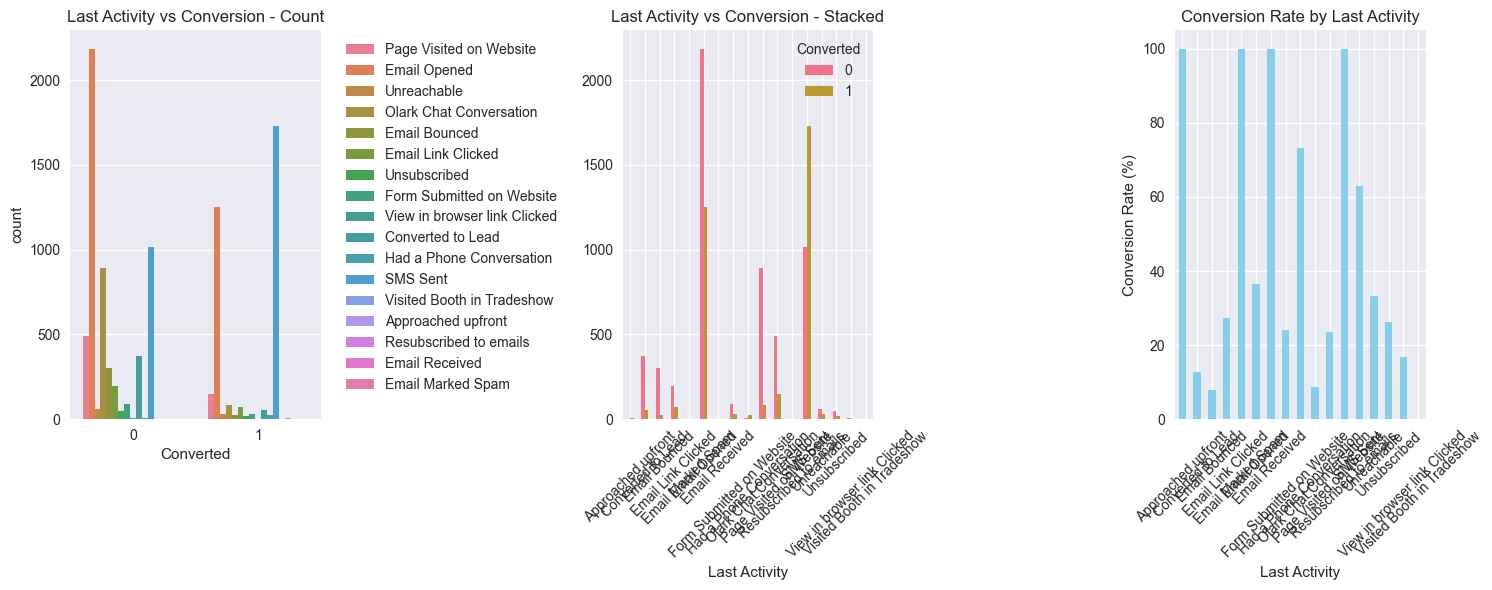

Last Activity: Chi-square = 1447.0102, p-value = 0.0000 (Significant)


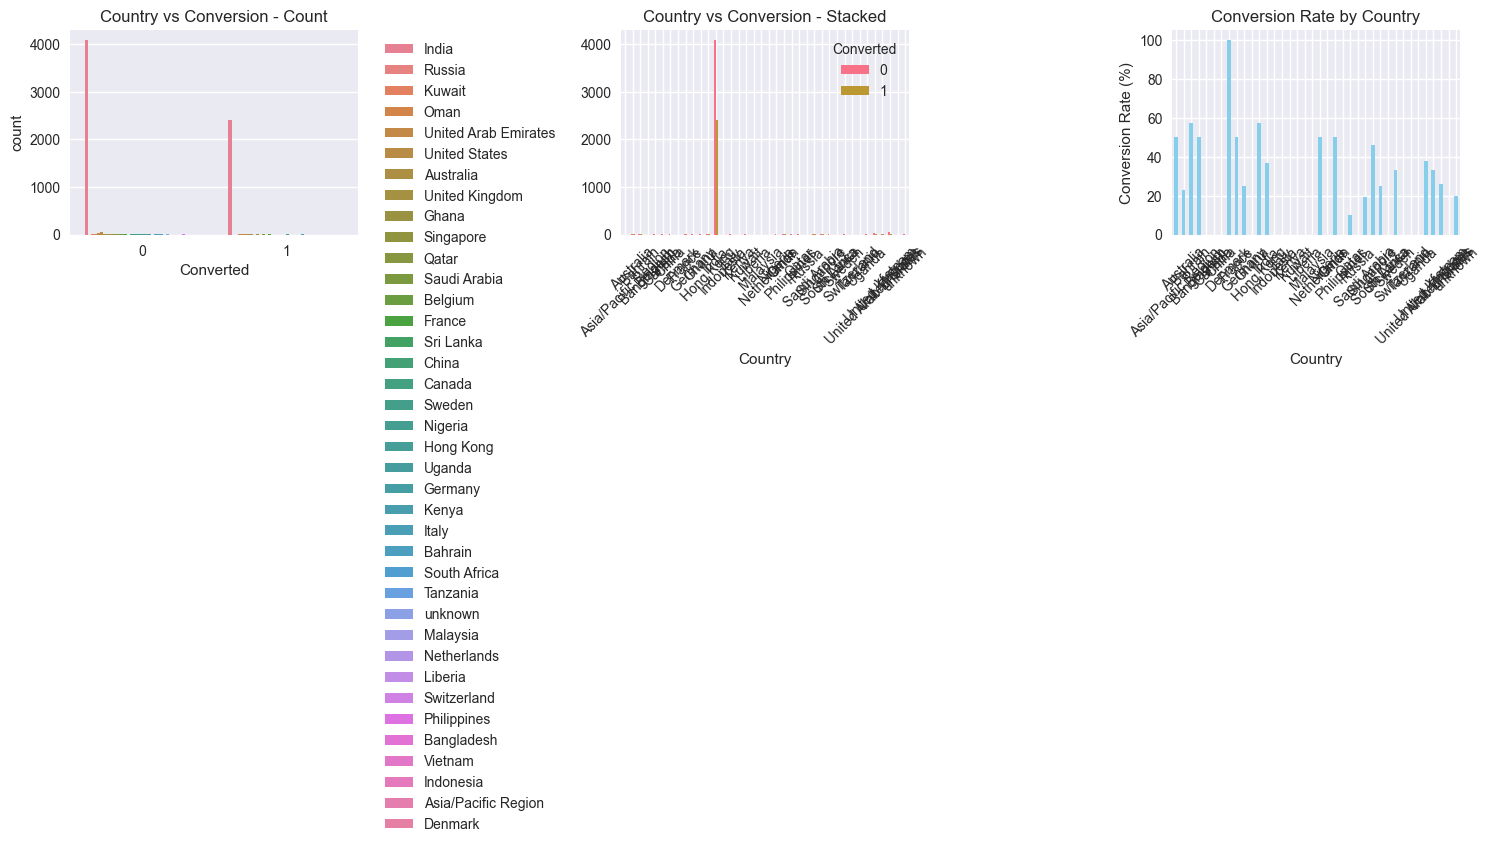

Country: Chi-square = 37.3001, p-value = 0.4553 (Not Significant)


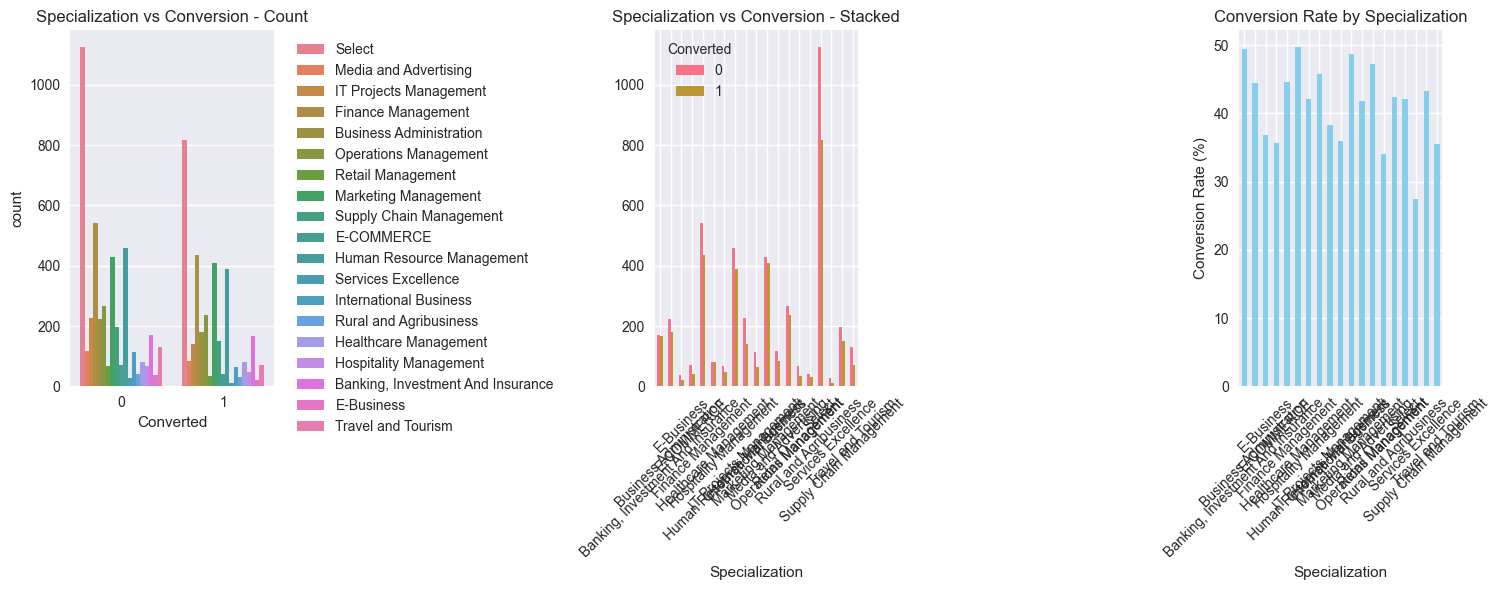

Specialization: Chi-square = 48.7132, p-value = 0.0001 (Significant)


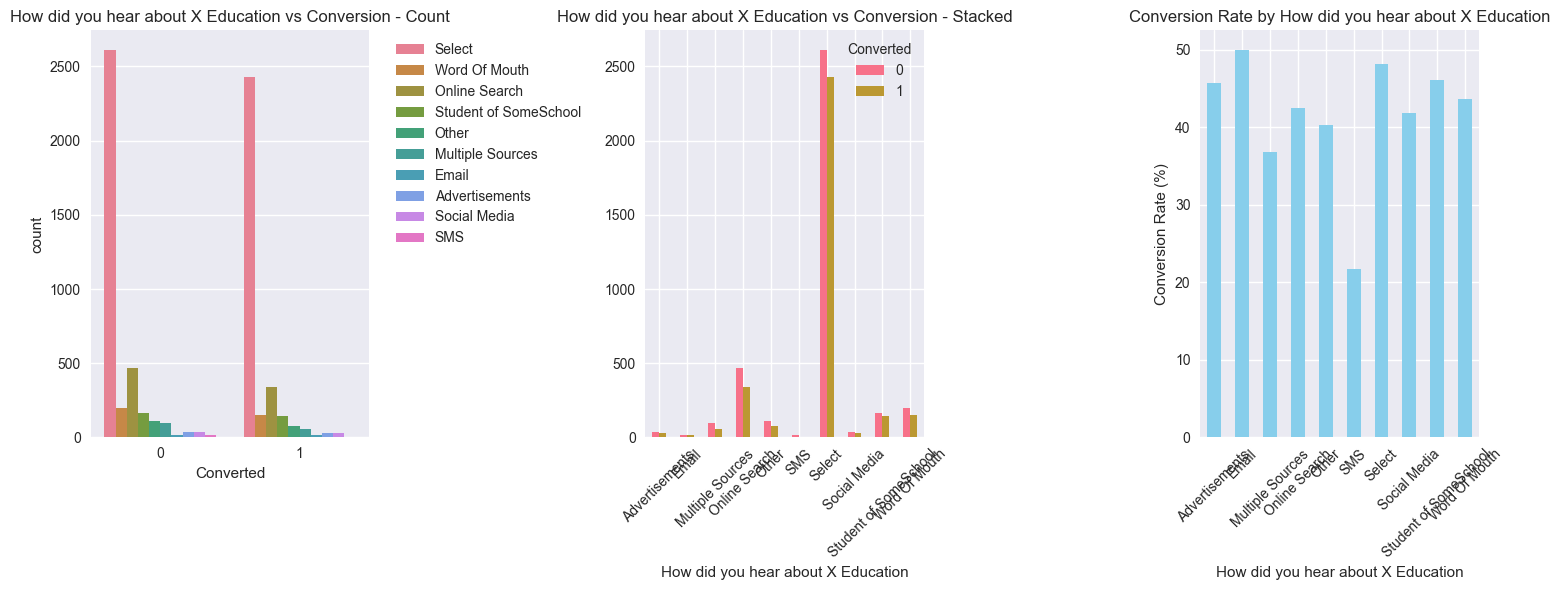

How did you hear about X Education: Chi-square = 27.2744, p-value = 0.0013 (Significant)


In [29]:
eda.bivariate_analysis()


CORRELATION ANALYSIS


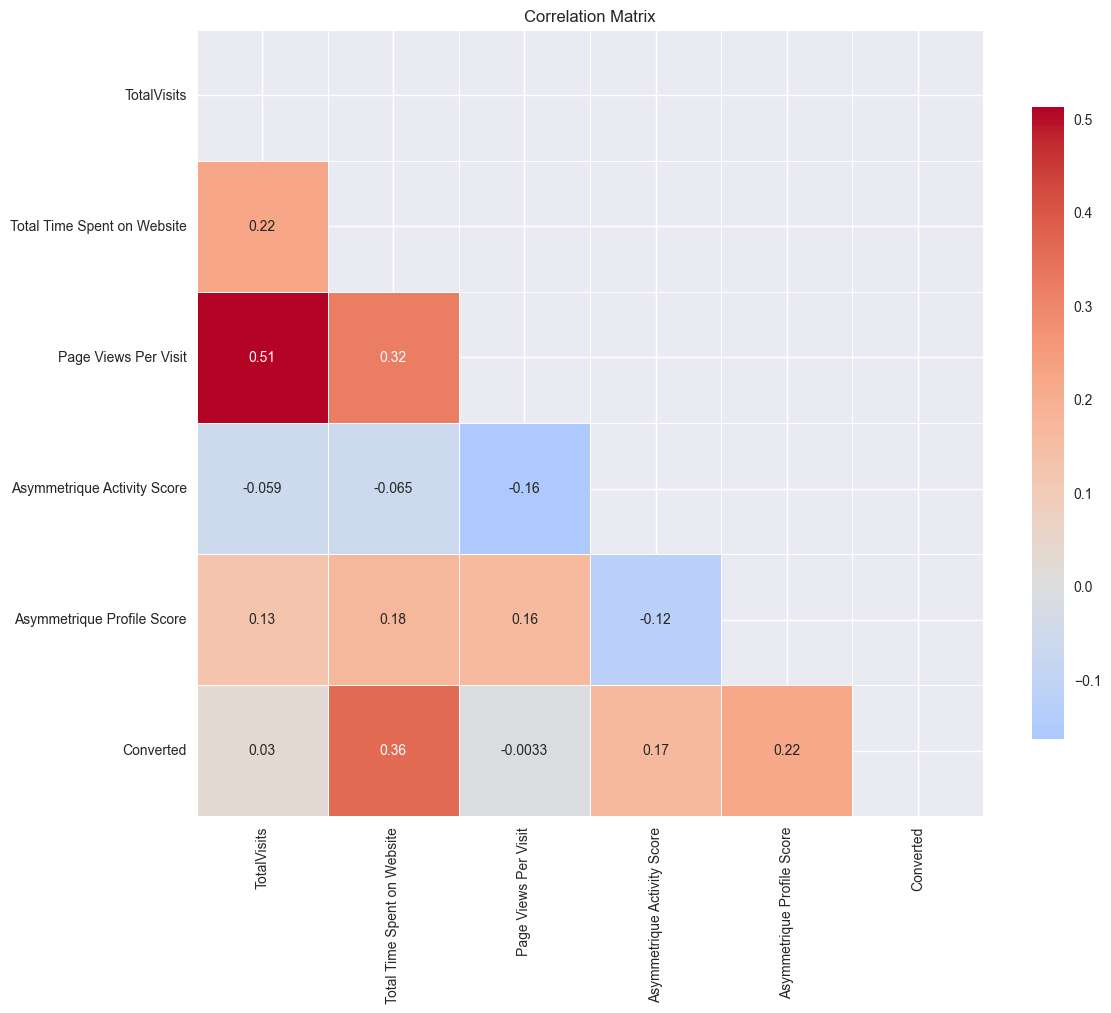


Correlation with Target Variable:
Total Time Spent on Website    0.362483
Asymmetrique Profile Score     0.218571
Asymmetrique Activity Score    0.167962
TotalVisits                    0.030395
Page Views Per Visit          -0.003328
Name: Converted, dtype: float64


In [30]:
eda.correlation_analysis()


OUTLIER ANALYSIS
TotalVisits: 267 outliers (2.89%)
Total Time Spent on Website: 0 outliers (0.00%)
Page Views Per Visit: 360 outliers (3.90%)
Asymmetrique Activity Score: 716 outliers (7.75%)
Asymmetrique Profile Score: 0 outliers (0.00%)


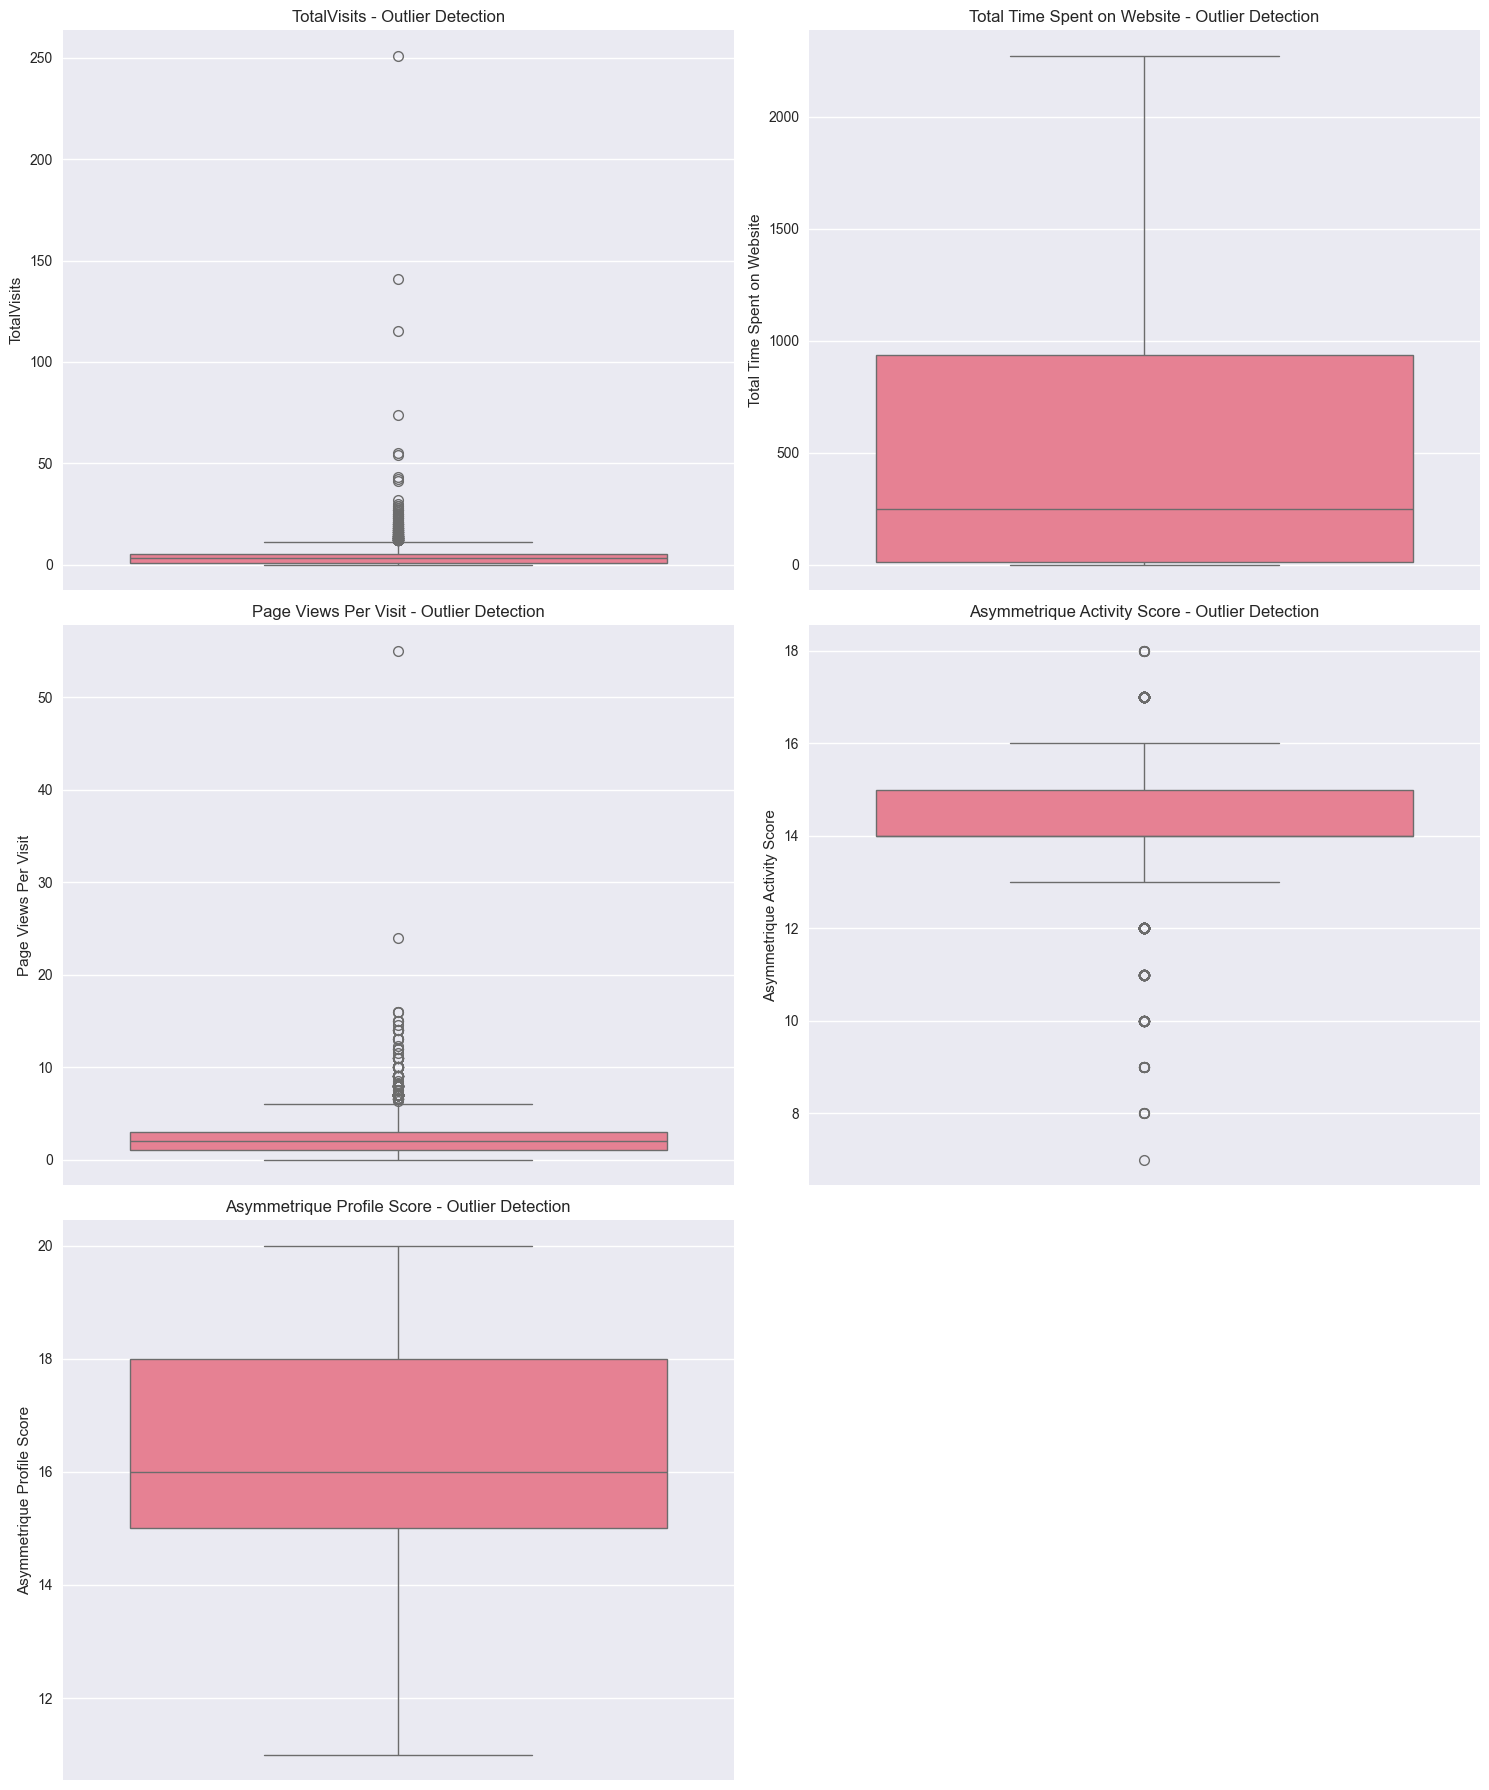

In [31]:
eda.outlier_analysis()


ADVANCED ANALYSIS


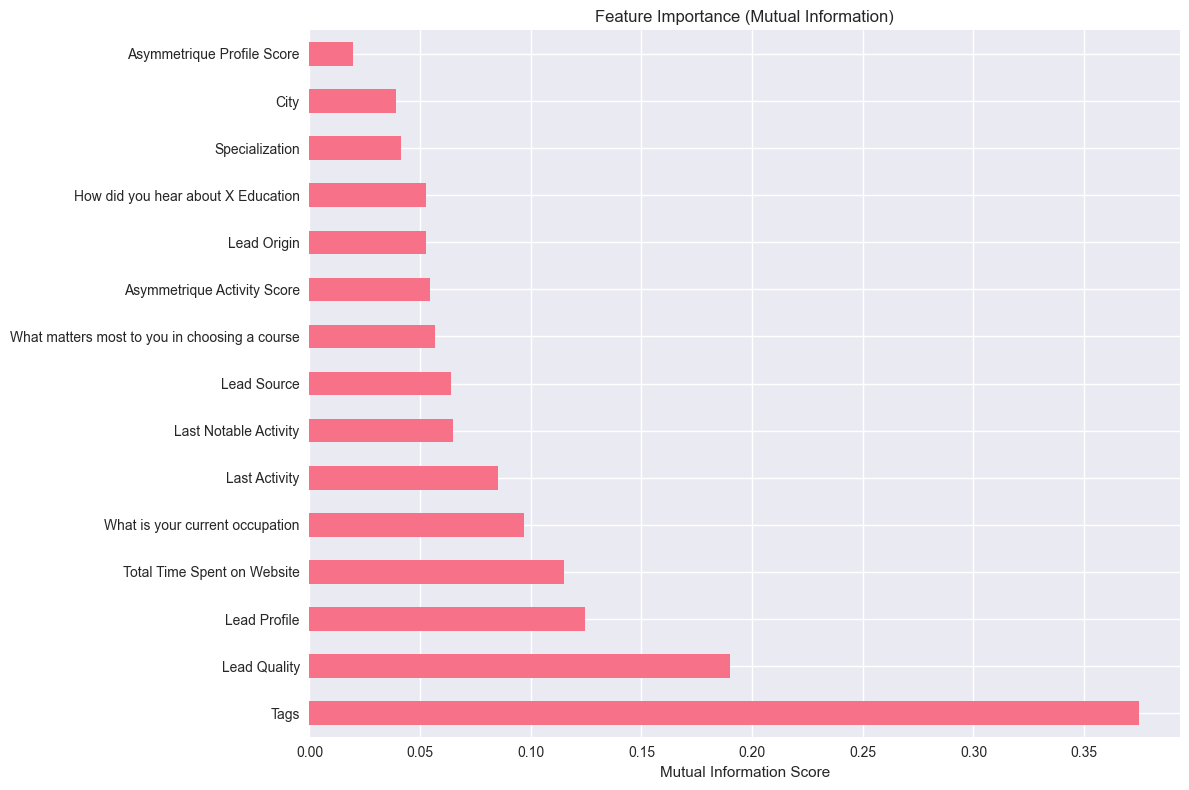

Top 10 Most Important Features:
Tags                                             0.374572
Lead Quality                                     0.189825
Lead Profile                                     0.124547
Total Time Spent on Website                      0.114890
What is your current occupation                  0.096983
Last Activity                                    0.085084
Last Notable Activity                            0.065059
Lead Source                                      0.064159
What matters most to you in choosing a course    0.056870
Asymmetrique Activity Score                      0.054275
dtype: float64
BUSINESS INSIGHTS
Lead Source Performance:
                   Total_Leads  Conversions  Conversion_Rate
Lead Source                                                 
Live Chat                    2            2         1.000000
WeLearn                      1            1         1.000000
NC_EDM                       1            1         1.000000
Welingak Website         

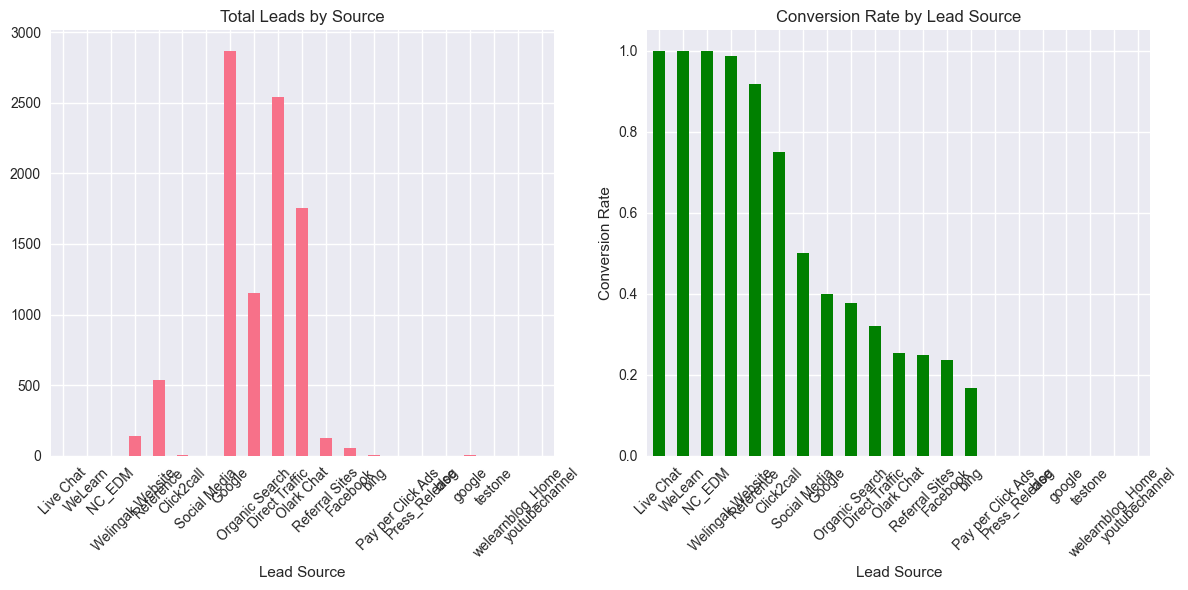


Website Engagement Analysis:
TotalVisits:
  Converted: 3.63
  Not Converted: 3.33
  Difference: 9.13%
Total Time Spent on Website:
  Converted: 738.55
  Not Converted: 330.40
  Difference: 123.53%
Page Views Per Visit:
  Converted: 2.35
  Not Converted: 2.37
  Difference: -0.63%

Last Activity Performance:
                          Count  Conversion_Rate
Last Activity                                   
Approached upfront            9         1.000000
Email Marked Spam             2         1.000000
Email Received                2         1.000000
Resubscribed to emails        1         1.000000
Had a Phone Conversation     30         0.733333
SMS Sent                   2745         0.629144
Email Opened               3437         0.364562
Unreachable                  93         0.333333
Email Link Clicked          267         0.273408
Unsubscribed                 61         0.262295


In [32]:
eda.advanced_analysis()


In [33]:
eda.generate_final_report()

COMPREHENSIVE EDA REPORT - SALES CONVERSION PREDICTION

1. DATASET OVERVIEW:
   - Total Records: 9,240
   - Total Features: 37
   - Conversion Rate: 38.54%

2. DATA QUALITY:
   - Features with >30% missing values: 6
   - Duplicate records: 0

3. KEY BUSINESS INSIGHTS:
   - Best performing lead source: Live Chat (1.00% conversion)
   - Top 5 predictive features: Tags, Lead Quality, Lead Profile, Total Time Spent on Website, What is your current occupation
   - Features with significant association with conversion: 6

4. TECHNICAL RECOMMENDATIONS:
   - Consider removing features with >50% missing values: ['Lead Quality']
   - Consider outlier treatment for: Asymmetrique Activity Score

5. MODELING RECOMMENDATIONS:
   - Use stratified sampling due to class imbalance
   - Consider ensemble methods (Random Forest, XGBoost)
   - Implement proper cross-validation
   - Focus on precision and recall along with accuracy



In [14]:
# only statistical analysis



# Comprehensive EDA for Sales Conversion Prediction - NO GRAPHS VERSION
# Statistical Analysis Only - Results for Decision Making

import pandas as pd
import numpy as np
import warnings
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

class SalesConversionEDA:
    """
    Statistical EDA class for Sales Conversion Prediction
    No visualizations - Pure statistical analysis for decision making
    """
    
    def __init__(self, df):
        self.df = df.copy()
        self.target = 'Converted'
        self.numerical_features = []
        self.categorical_features = []
        self.business_insights = {}
        self.technical_insights = {}
        self.analysis_results = {}
        
    def initial_data_overview(self):
        """
        Initial data exploration and overview
        """
        print("="*80)
        print("INITIAL DATA OVERVIEW")
        print("="*80)
        
        # Basic dataset info
        results = {
            'dataset_shape': self.df.shape,
            'total_records': self.df.shape[0],
            'total_features': self.df.shape[1],
            'columns': list(self.df.columns),
            'dtypes': dict(self.df.dtypes),
            'first_5_rows': self.df.head().to_dict(),
            'basic_stats': self.df.describe().to_dict()
        }
        
        print(f"Dataset Shape: {results['dataset_shape']}")
        print(f"Total Records: {results['total_records']:,}")
        print(f"Total Features: {results['total_features']:,}")
        print(f"Columns: {results['columns']}")
        
        # Target variable analysis
        if self.target in self.df.columns:
            target_dist = self.df[self.target].value_counts()
            conversion_rate = target_dist[1]/target_dist.sum()*100 if 1 in target_dist.index else 0
            
            results['target_distribution'] = dict(target_dist)
            results['conversion_rate'] = conversion_rate
            
            print(f"\nTarget Variable Distribution: {dict(target_dist)}")
            print(f"Conversion Rate: {conversion_rate:.2f}%")
            
            self.business_insights['conversion_rate'] = conversion_rate
        
        # Data types summary
        dtype_summary = self.df.dtypes.value_counts().to_dict()
        results['dtype_summary'] = dtype_summary
        print(f"\nData Types Summary: {dtype_summary}")
        
        self.analysis_results['initial_overview'] = results
        return results
        
    def data_quality_assessment(self):
        """
        Comprehensive data quality assessment
        """
        print("="*80)
        print("DATA QUALITY ASSESSMENT")
        print("="*80)
        
        # Missing values analysis
        missing_data = self.df.isnull().sum()
        missing_percent = (missing_data / len(self.df)) * 100
        
        missing_df = pd.DataFrame({
            'Column': missing_data.index,
            'Missing_Count': missing_data.values,
            'Missing_Percentage': missing_percent.values
        }).sort_values('Missing_Percentage', ascending=False)
        
        missing_summary = missing_df[missing_df['Missing_Count'] > 0]
        
        print("Missing Values Summary:")
        for _, row in missing_summary.iterrows():
            print(f"  {row['Column']}: {row['Missing_Count']} ({row['Missing_Percentage']:.2f}%)")
        
        # Duplicate records
        duplicates = self.df.duplicated().sum()
        print(f"\nDuplicate Records: {duplicates}")
        
        # Unique values per column
        unique_counts = {}
        for col in self.df.columns:
            unique_counts[col] = self.df[col].nunique()
        
        print(f"\nUnique Values per Column:")
        for col, count in unique_counts.items():
            print(f"  {col}: {count}")
        
        # High cardinality features (>50% unique values)
        high_cardinality = []
        for col, count in unique_counts.items():
            if count > len(self.df) * 0.5:
                high_cardinality.append(col)
        
        if high_cardinality:
            print(f"\nHigh Cardinality Features (>50% unique): {high_cardinality}")
        
        results = {
            'missing_summary': missing_summary.to_dict('records'),
            'duplicates': duplicates,
            'unique_counts': unique_counts,
            'high_cardinality': high_cardinality
        }
        
        self.technical_insights['data_quality'] = results
        self.analysis_results['data_quality'] = results
        return results
        
    def feature_categorization(self):
        """
        Categorize features into numerical and categorical
        """
        print("="*80)
        print("FEATURE CATEGORIZATION")
        print("="*80)
        
        # Identify numerical and categorical features
        self.numerical_features = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_features = self.df.select_dtypes(include=['object']).columns.tolist()
        
        # Remove target and ID columns
        if self.target in self.numerical_features:
            self.numerical_features.remove(self.target)
        if 'Prospect ID' in self.categorical_features:
            self.categorical_features.remove('Prospect ID')
        if 'Lead Number' in self.numerical_features:
            self.numerical_features.remove('Lead Number')
            
        print(f"Numerical Features ({len(self.numerical_features)}):")
        for feature in self.numerical_features:
            print(f"  - {feature}")
        
        print(f"\nCategorical Features ({len(self.categorical_features)}):")
        for feature in self.categorical_features:
            print(f"  - {feature}")
        
        results = {
            'numerical_features': self.numerical_features,
            'categorical_features': self.categorical_features,
            'numerical_count': len(self.numerical_features),
            'categorical_count': len(self.categorical_features)
        }
        
        self.analysis_results['feature_categorization'] = results
        return results
        
    def univariate_analysis(self):
        """
        Statistical univariate analysis for all features
        """
        print("="*80)
        print("UNIVARIATE ANALYSIS")
        print("="*80)
        
        results = {}
        
        # Numerical features statistics
        numerical_stats = {}
        for feature in self.numerical_features:
            feature_data = self.df[feature].dropna()
            if len(feature_data) > 0:
                stats_dict = {
                    'count': len(feature_data),
                    'mean': feature_data.mean(),
                    'median': feature_data.median(),
                    'std': feature_data.std(),
                    'min': feature_data.min(),
                    'max': feature_data.max(),
                    'q25': feature_data.quantile(0.25),
                    'q75': feature_data.quantile(0.75),
                    'skewness': feature_data.skew(),
                    'kurtosis': feature_data.kurtosis()
                }
                numerical_stats[feature] = stats_dict
                
                print(f"\n{feature} Statistics:")
                print(f"  Count: {stats_dict['count']}")
                print(f"  Mean: {stats_dict['mean']:.4f}")
                print(f"  Median: {stats_dict['median']:.4f}")
                print(f"  Std: {stats_dict['std']:.4f}")
                print(f"  Min: {stats_dict['min']:.4f}")
                print(f"  Max: {stats_dict['max']:.4f}")
                print(f"  Skewness: {stats_dict['skewness']:.4f}")
                print(f"  Kurtosis: {stats_dict['kurtosis']:.4f}")
        
        # Categorical features statistics
        categorical_stats = {}
        for feature in self.categorical_features:
            value_counts = self.df[feature].value_counts()
            top_10 = value_counts.head(10)
            
            stats_dict = {
                'unique_count': len(value_counts),
                'top_categories': dict(top_10),
                'most_frequent': value_counts.index[0] if len(value_counts) > 0 else None,
                'most_frequent_count': value_counts.iloc[0] if len(value_counts) > 0 else 0,
                'most_frequent_percentage': (value_counts.iloc[0] / len(self.df)) * 100 if len(value_counts) > 0 else 0
            }
            categorical_stats[feature] = stats_dict
            
            print(f"\n{feature} Statistics:")
            print(f"  Unique Categories: {stats_dict['unique_count']}")
            print(f"  Most Frequent: {stats_dict['most_frequent']} ({stats_dict['most_frequent_percentage']:.2f}%)")
            print(f"  Top 10 Categories: {dict(top_10)}")
        
        results = {
            'numerical_stats': numerical_stats,
            'categorical_stats': categorical_stats
        }
        
        self.analysis_results['univariate_analysis'] = results
        return results
        
    def bivariate_analysis(self):
        """
        Statistical bivariate analysis with target variable
        """
        print("="*80)
        print("BIVARIATE ANALYSIS")
        print("="*80)
        
        results = {}
        
        # Numerical features vs Target
        numerical_target_analysis = {}
        for feature in self.numerical_features:
            converted = self.df[self.df[self.target] == 1][feature].dropna()
            not_converted = self.df[self.df[self.target] == 0][feature].dropna()
            
            if len(converted) > 0 and len(not_converted) > 0:
                # Statistical test
                try:
                    stat, p_value = stats.mannwhitneyu(converted, not_converted, alternative='two-sided')
                except:
                    stat, p_value = np.nan, np.nan
                
                analysis = {
                    'converted_mean': converted.mean(),
                    'not_converted_mean': not_converted.mean(),
                    'converted_median': converted.median(),
                    'not_converted_median': not_converted.median(),
                    'converted_std': converted.std(),
                    'not_converted_std': not_converted.std(),
                    'mean_difference': converted.mean() - not_converted.mean(),
                    'median_difference': converted.median() - not_converted.median(),
                    'mannwhitney_stat': stat,
                    'mannwhitney_pvalue': p_value,
                    'significant': p_value < 0.05 if not np.isnan(p_value) else False
                }
                
                numerical_target_analysis[feature] = analysis
                
                print(f"\n{feature} vs Target:")
                print(f"  Converted Mean: {analysis['converted_mean']:.4f}")
                print(f"  Not Converted Mean: {analysis['not_converted_mean']:.4f}")
                print(f"  Mean Difference: {analysis['mean_difference']:.4f}")
                print(f"  Mann-Whitney p-value: {analysis['mannwhitney_pvalue']:.6f}")
                print(f"  Significant: {analysis['significant']}")
        
        # Categorical features vs Target
        categorical_target_analysis = {}
        significant_associations = []
        
        for feature in self.categorical_features:
            try:
                crosstab = pd.crosstab(self.df[feature], self.df[self.target])
                
                # Conversion rates by category
                conversion_rates = crosstab.div(crosstab.sum(axis=1), axis=0)[1] * 100
                
                # Chi-square test
                chi2, p_value, dof, expected = chi2_contingency(crosstab)
                
                analysis = {
                    'crosstab': crosstab.to_dict(),
                    'conversion_rates': dict(conversion_rates),
                    'chi2_statistic': chi2,
                    'chi2_pvalue': p_value,
                    'degrees_of_freedom': dof,
                    'significant': p_value < 0.05,
                    'total_categories': len(crosstab),
                    'best_converting_category': conversion_rates.idxmax(),
                    'best_conversion_rate': conversion_rates.max(),
                    'worst_converting_category': conversion_rates.idxmin(),
                    'worst_conversion_rate': conversion_rates.min()
                }
                
                categorical_target_analysis[feature] = analysis
                
                if p_value < 0.05:
                    significant_associations.append((feature, p_value, chi2))
                
                print(f"\n{feature} vs Target:")
                print(f"  Chi-square: {chi2:.4f}, p-value: {p_value:.6f}")
                print(f"  Significant: {analysis['significant']}")
                print(f"  Best Converting Category: {analysis['best_converting_category']} ({analysis['best_conversion_rate']:.2f}%)")
                print(f"  Worst Converting Category: {analysis['worst_converting_category']} ({analysis['worst_conversion_rate']:.2f}%)")
                
            except Exception as e:
                print(f"  {feature}: Analysis failed - {str(e)}")
        
        results = {
            'numerical_target_analysis': numerical_target_analysis,
            'categorical_target_analysis': categorical_target_analysis,
            'significant_associations': significant_associations
        }
        
        self.business_insights['significant_associations'] = significant_associations
        self.analysis_results['bivariate_analysis'] = results
        return results
        
    def correlation_analysis(self):
        """
        Correlation analysis for numerical features
        """
        print("="*80)
        print("CORRELATION ANALYSIS")
        print("="*80)
        
        results = {}
        
        if len(self.numerical_features) > 1:
            # Correlation matrix
            numerical_df = self.df[self.numerical_features + [self.target]]
            correlation_matrix = numerical_df.corr()
            
            # Correlation with target
            target_corr = correlation_matrix[self.target].drop(self.target).sort_values(key=abs, ascending=False)
            
            print("Correlation with Target Variable:")
            for feature, corr in target_corr.items():
                print(f"  {feature}: {corr:.4f}")
            
            # High correlation pairs (multicollinearity check)
            high_corr_pairs = []
            for i in range(len(correlation_matrix.columns)):
                for j in range(i+1, len(correlation_matrix.columns)):
                    corr_value = correlation_matrix.iloc[i, j]
                    if abs(corr_value) > 0.7:
                        high_corr_pairs.append((
                            correlation_matrix.columns[i], 
                            correlation_matrix.columns[j], 
                            corr_value
                        ))
            
            if high_corr_pairs:
                print("\nHigh Correlation Pairs (>0.7):")
                for pair in high_corr_pairs:
                    print(f"  {pair[0]} - {pair[1]}: {pair[2]:.4f}")
            else:
                print("\nNo high correlation pairs found (>0.7)")
            
            results = {
                'correlation_matrix': correlation_matrix.to_dict(),
                'target_correlations': dict(target_corr),
                'high_correlation_pairs': high_corr_pairs,
                'strongest_positive_corr': target_corr.max(),
                'strongest_negative_corr': target_corr.min(),
                'most_correlated_feature': target_corr.idxmax(),
                'least_correlated_feature': target_corr.idxmin()
            }
            
            self.technical_insights['correlation_analysis'] = results
        
        self.analysis_results['correlation_analysis'] = results
        return results
        
    def advanced_analysis(self):
        """
        Advanced statistical analysis including feature importance
        """
        print("="*80)
        print("ADVANCED ANALYSIS")
        print("="*80)
        
        results = {}
        
        # Feature importance using mutual information
        try:
            df_encoded = self.df.copy()
            
            # Label encode categorical variables
            le = LabelEncoder()
            for feature in self.categorical_features:
                df_encoded[feature] = le.fit_transform(df_encoded[feature].astype(str))
            
            # Calculate mutual information
            features = self.numerical_features + self.categorical_features
            X = df_encoded[features].fillna(0)
            y = df_encoded[self.target]
            
            mi_scores = mutual_info_classif(X, y, random_state=42)
            mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)
            
            print("Feature Importance (Mutual Information):")
            for feature, score in mi_scores.head(15).items():
                print(f"  {feature}: {score:.4f}")
            
            results['feature_importance'] = dict(mi_scores)
            results['top_10_features'] = dict(mi_scores.head(10))
            
            self.technical_insights['feature_importance'] = mi_scores
            
        except Exception as e:
            print(f"Feature importance analysis failed: {str(e)}")
        
        # Class imbalance analysis
        if self.target in self.df.columns:
            class_distribution = self.df[self.target].value_counts()
            minority_class = class_distribution.min()
            majority_class = class_distribution.max()
            imbalance_ratio = majority_class / minority_class
            
            results['class_imbalance'] = {
                'class_distribution': dict(class_distribution),
                'imbalance_ratio': imbalance_ratio,
                'is_imbalanced': imbalance_ratio > 2
            }
            
            print(f"\nClass Imbalance Analysis:")
            print(f"  Class Distribution: {dict(class_distribution)}")
            print(f"  Imbalance Ratio: {imbalance_ratio:.2f}")
            print(f"  Is Imbalanced: {imbalance_ratio > 2}")
        
        self.analysis_results['advanced_analysis'] = results
        return results
        
    def outlier_analysis(self):
        """
        Statistical outlier analysis
        """
        print("="*80)
        print("OUTLIER ANALYSIS")
        print("="*80)
        
        results = {}
        
        if self.numerical_features:
            outlier_summary = {}
            
            for feature in self.numerical_features:
                feature_data = self.df[feature].dropna()
                
                if len(feature_data) > 0:
                    Q1 = feature_data.quantile(0.25)
                    Q3 = feature_data.quantile(0.75)
                    IQR = Q3 - Q1
                    
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
                    
                    outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]
                    outlier_percentage = (len(outliers) / len(feature_data)) * 100
                    
                    # Z-score method
                    z_scores = np.abs(stats.zscore(feature_data))
                    z_outliers = feature_data[z_scores > 3]
                    z_outlier_percentage = (len(z_outliers) / len(feature_data)) * 100
                    
                    outlier_info = {
                        'iqr_outlier_count': len(outliers),
                        'iqr_outlier_percentage': outlier_percentage,
                        'zscore_outlier_count': len(z_outliers),
                        'zscore_outlier_percentage': z_outlier_percentage,
                        'lower_bound': lower_bound,
                        'upper_bound': upper_bound,
                        'Q1': Q1,
                        'Q3': Q3,
                        'IQR': IQR
                    }
                    
                    outlier_summary[feature] = outlier_info
                    
                    print(f"\n{feature} Outliers:")
                    print(f"  IQR Method: {len(outliers)} outliers ({outlier_percentage:.2f}%)")
                    print(f"  Z-Score Method: {len(z_outliers)} outliers ({z_outlier_percentage:.2f}%)")
                    print(f"  Bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")
            
            results['outlier_summary'] = outlier_summary
            
            # Features with high outlier percentage
            high_outlier_features = []
            for feature, info in outlier_summary.items():
                if info['iqr_outlier_percentage'] > 5:
                    high_outlier_features.append(feature)
            
            results['high_outlier_features'] = high_outlier_features
            
            if high_outlier_features:
                print(f"\nFeatures with >5% outliers: {high_outlier_features}")
            
            self.technical_insights['outliers'] = outlier_summary
        
        self.analysis_results['outlier_analysis'] = results
        return results
        
    def business_insights_analysis(self):
        """
        Generate business-specific insights
        """
        print("="*80)
        print("BUSINESS INSIGHTS")
        print("="*80)
        
        results = {}
        
        # Lead source analysis
        if 'Lead Source' in self.df.columns:
            lead_source_stats = self.df.groupby('Lead Source')[self.target].agg(['count', 'sum', 'mean'])
            lead_source_stats.columns = ['Total_Leads', 'Conversions', 'Conversion_Rate']
            lead_source_stats = lead_source_stats.sort_values('Conversion_Rate', ascending=False)
            
            results['lead_source_performance'] = lead_source_stats.to_dict('index')
            
            print("Lead Source Performance:")
            for source, stats in lead_source_stats.iterrows():
                print(f"  {source}: {stats['Total_Leads']} leads, {stats['Conversions']} conversions, {stats['Conversion_Rate']:.2%} rate")
        
        # Website engagement analysis
        website_features = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
        website_features = [f for f in website_features if f in self.df.columns]
        
        if website_features:
            website_analysis = {}
            print("\nWebsite Engagement Analysis:")
            for feature in website_features:
                converted_avg = self.df[self.df[self.target] == 1][feature].mean()
                not_converted_avg = self.df[self.df[self.target] == 0][feature].mean()
                difference_pct = ((converted_avg - not_converted_avg) / not_converted_avg * 100) if not_converted_avg != 0 else 0
                
                website_analysis[feature] = {
                    'converted_avg': converted_avg,
                    'not_converted_avg': not_converted_avg,
                    'difference_percentage': difference_pct
                }
                
                print(f"  {feature}:")
                print(f"    Converted: {converted_avg:.2f}")
                print(f"    Not Converted: {not_converted_avg:.2f}")
                print(f"    Difference: {difference_pct:.2f}%")
            
            results['website_engagement'] = website_analysis
        
        # Activity-based insights
        if 'Last Activity' in self.df.columns:
            activity_stats = self.df.groupby('Last Activity')[self.target].agg(['count', 'mean'])
            activity_stats.columns = ['Count', 'Conversion_Rate']
            activity_stats = activity_stats.sort_values('Conversion_Rate', ascending=False)
            
            results['activity_performance'] = activity_stats.to_dict('index')
            
            print("\nLast Activity Performance:")
            for activity, stats in activity_stats.head(10).iterrows():
                print(f"  {activity}: {stats['Count']} instances, {stats['Conversion_Rate']:.2%} conversion rate")
        
        self.business_insights.update(results)
        self.analysis_results['business_insights'] = results
        return results
        
    def generate_comprehensive_report(self):
        """
        Generate comprehensive final report with all insights
        """
        print("="*100)
        print("COMPREHENSIVE EDA REPORT - SALES CONVERSION PREDICTION")
        print("="*100)
        
        # Dataset overview
        print("\n1. DATASET OVERVIEW:")
        print(f"   - Total Records: {self.df.shape[0]:,}")
        print(f"   - Total Features: {self.df.shape[1]:,}")
        print(f"   - Conversion Rate: {self.business_insights.get('conversion_rate', 0):.2f}%")
        
        # Data quality summary
        print("\n2. DATA QUALITY SUMMARY:")
        if 'data_quality' in self.analysis_results:
            dq = self.analysis_results['data_quality']
            high_missing = [item for item in dq['missing_summary'] if item['Missing_Percentage'] > 30]
            print(f"   - Features with >30% missing: {len(high_missing)}")
            print(f"   - Duplicate records: {dq['duplicates']}")
            print(f"   - High cardinality features: {len(dq['high_cardinality'])}")
        
        # Key findings
        print("\n3. KEY STATISTICAL FINDINGS:")
        if 'bivariate_analysis' in self.analysis_results:
            ba = self.analysis_results['bivariate_analysis']
            sig_numerical = sum(1 for analysis in ba['numerical_target_analysis'].values() if analysis['significant'])
            sig_categorical = len(ba['significant_associations'])
            print(f"   - Numerical features significantly different: {sig_numerical}")
            print(f"   - Categorical features significantly associated: {sig_categorical}")
        
        # Feature importance
        print("\n4. FEATURE IMPORTANCE:")
        if 'advanced_analysis' in self.analysis_results and 'top_10_features' in self.analysis_results['advanced_analysis']:
            top_features = list(self.analysis_results['advanced_analysis']['top_10_features'].keys())[:5]
            print(f"   - Top 5 predictive features: {top_features}")
        
        # Business recommendations
        print("\n5. BUSINESS RECOMMENDATIONS:")
        if 'lead_source_performance' in self.business_insights:
            best_source = max(self.business_insights['lead_source_performance'].items(), 
                            key=lambda x: x[1]['Conversion_Rate'])
            print(f"   - Focus on best lead source: {best_source[0]} ({best_source[1]['Conversion_Rate']:.2%})")
        
        # Technical recommendations
        print("\n6. TECHNICAL RECOMMENDATIONS:")
        if 'advanced_analysis' in self.analysis_results and 'class_imbalance' in self.analysis_results['advanced_analysis']:
            if self.analysis_results['advanced_analysis']['class_imbalance']['is_imbalanced']:
                print("   - Address class imbalance with sampling techniques")
        
        if 'correlation_analysis' in self.analysis_results and 'high_correlation_pairs' in self.analysis_results['correlation_analysis']:
            high_corr_pairs = self.analysis_results['correlation_analysis']['high_correlation_pairs']
            if high_corr_pairs:
                print("   - Address multicollinearity between highly correlated features")
        
        print("\n7. MODELING STRATEGY:")
        print("   - Use stratified sampling for train/test split")
        print("   - Consider ensemble methods for better performance")
        print("   - Implement proper feature engineering")
        print("   - Focus on both precision and recall metrics")
        
        print("\n" + "="*100)
        
        return self.analysis_results
        
    def run_complete_analysis(self):
        """
        Run the complete EDA analysis pipeline
        """
        print("Starting Comprehensive EDA Analysis...")
        print("="*50)
        
        # Execute all analysis steps
        self.initial_data_overview()
        self.data_quality_assessment()
        self.feature_categorization()
        self.univariate_analysis()
        self.bivariate_analysis()
        self.correlation_analysis()
        self.outlier_analysis()
        self.advanced_analysis()
        self.business_insights_analysis()
        
        # Generate final report
        final_results = self.generate_comprehensive_report()
        
        print("\nEDA Analysis Complete!")
        print("="*50)
        
        return final_results

# Usage Example:
def run_eda(df):
    """
    Main function to run EDA analysis
    """
    eda = SalesConversionEDA(df)
    results = eda.run_complete_analysis()
    return eda, results

# Example usage:
df = pd.read_csv(r'C:\Users\Minfy.DESKTOP-3E50D5N\Documents\student_project\student_social_media\Lead Scoring.csv')
eda_analyzer, analysis_results = run_eda(df)

print("Statistical EDA Framework Ready!")
print("Usage: eda_analyzer, results = run_eda(your_dataframe)")
print("This will provide comprehensive statistical analysis without any graphs.")

Starting Comprehensive EDA Analysis...
INITIAL DATA OVERVIEW
Dataset Shape: (9240, 37)
Total Records: 9,240
Total Features: 37
Columns: ['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']

T